In [1]:
import numpy as np
import pandas as pd
from glob import glob
import gzip
import shutil
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import math

# Preprocessing

In [2]:
instruments = ['USD000000TOD', 'USD000UTSTOM', 'EUR_RUB__TOD', 'EUR_RUB__TOM', 'EURUSD000TOM', 'EURUSD000TOD']

instruments_info = {'USD000000TOD': {'SCHEDULE': 174500000000, 'PRICE_STEP': 0.0025},
                    'USD000UTSTOM': {'SCHEDULE': 235000000000, 'PRICE_STEP': 0.0025},
                    'EUR_RUB__TOD': {'SCHEDULE': 150000000000, 'PRICE_STEP': 0.0025},
                    'EUR_RUB__TOM': {'SCHEDULE': 235000000000, 'PRICE_STEP': 0.0025},
                    'EURUSD000TOM': {'SCHEDULE': 235000000000, 'PRICE_STEP': 0.00001},
                    'EURUSD000TOD': {'SCHEDULE': 150000000000, 'PRICE_STEP': 0.00001}}

In [26]:
for file in tqdm(glob('.\\MOEX-FX\\*\\OrderLog*.txt.gz')):
    df = pd.read_csv(file)
    date = file[-15: -7]
    for ins in instruments:
        new_df = df.loc[df['SECCODE'] == ins]
        new_df.to_csv('fx_separated/' + ins + '/orderlog' + date + '.txt')

100%|███████████████████████████████████████████████████████████████████████████████████| 64/64 [2:11:09<00:00, 122.96s/it]


# Generate Spectrum and Orderbooks

In [3]:
class Spectrum:
    def __init__(self, price_step):
        self.price_step = price_step
        self.buy_bins = []
        self.all_buy_bins = []
        self.all_buy_volumes = []
        self.all_sell_bins = []
        self.all_sell_volumes = []
        self.sell_bins = []
        self.best_sell = -1
        self.best_buy = -1
        self.buy_volumes = [0 for i in range(50)]
        self.sell_volumes = [0 for i in range(50)]
        self.spectrum_sell_bins = []
        self.spectrum_buy_bins = []
        self.spectrum_sell = [0 for i in range(10)]
        self.spectrum_buy = [0 for i in range(10)]

    def insert_to_buy(self, price, volume):
        max_price = self.all_buy_bins[0]
        # new one is greater than the currently recorded maximum
        if price > max_price:
            dist = math.ceil((price - max_price) / self.price_step)
            self.all_buy_bins = [i for i in np.arange(price, max_price, -self.price_step)] + self.all_buy_bins
            self.all_buy_volumes = [0 for i in range(len(self.all_buy_bins) - len(self.all_buy_volumes))] + self.all_buy_volumes
            self.all_buy_volumes[0] += volume
            return 0
        else:
            idx = math.ceil((max_price - price) / self.price_step)
            if idx < len(self.all_buy_bins):
                self.all_buy_volumes[idx] += volume
                return idx
            else:
                dist = idx - len(self.all_buy_bins) + 1
                self.all_buy_bins = self.all_buy_bins + [i for i in np.arange(self.all_buy_bins[-1] - self.price_step, price - 1, -self.price_step)]
                self.all_buy_volumes = self.all_buy_volumes + [0 for i in range(len(self.all_buy_bins) - len(self.all_buy_volumes))]
                self.all_buy_volumes[idx] += volume
                return idx

    def insert_to_sell(self, price, volume):
        min_price = self.all_sell_bins[0]
        # new one is less than the currently recorded minimum
        if price < min_price:
            dist = math.ceil((min_price - price) / self.price_step)
            self.all_sell_bins = [i for i in np.arange(price, min_price, self.price_step)] + self.all_sell_bins
            self.all_sell_volumes = [0 for i in range(len(self.all_sell_bins) - len(self.all_sell_volumes))] + self.all_sell_volumes
            self.all_sell_volumes[0] += volume
            return 0
        else:
            idx = math.ceil((price - min_price) / self.price_step)
            if idx < len(self.all_sell_bins):
                self.all_sell_volumes[idx] += volume
                return idx
            else:
                dist = idx - len(self.all_sell_bins) + 1
                self.all_sell_bins = self.all_sell_bins + [i for i in np.arange(self.all_sell_bins[-1] + self.price_step, price + 1, self.price_step)]
                self.all_sell_volumes = self.all_sell_volumes + [0 for i in range(len(self.all_sell_bins) - len(self.all_sell_volumes))]
                self.all_sell_volumes[idx] += volume
                return idx

    def delete_from_buy(self, price, volume):
        max_price = self.all_buy_bins[0]
        idx = math.ceil((max_price - price) / self.price_step)
        if 0 <= idx < len(self.all_buy_bins):
            if volume < self.all_buy_volumes[idx]:
                self.all_buy_volumes[idx] -= volume
                return idx
            # find first non-zero element
            else:
                self.all_buy_volumes[idx] = 0
                while self.all_buy_volumes[idx] == 0:
                    if (idx == len(self.all_buy_volumes) - 1):
                        break
                    idx += 1
                return idx
        else:
            return -1

    def delete_from_sell(self, price, volume):
        min_price = self.all_sell_bins[0]
        idx = math.ceil((price - min_price) / self.price_step)
        if 0 <= idx < len(self.all_sell_bins):
            if volume < self.all_sell_volumes[idx]:
                self.all_sell_volumes[idx] -= volume
                return idx
            # find first non-zero element
            else:
                self.all_sell_volumes[idx] = 0
                while self.all_sell_volumes[idx] == 0:
                    if (idx == len(self.all_sell_volumes) - 1):
                        break
                    idx += 1
                return idx
        else:
            return -1

    def find_idx_sell(self, price):
        k = math.ceil((price - self.best_sell) / self.price_step)
        if k == 50:
            k = 49
        return int(k)

    def find_idx_buy(self, price):
        k = math.ceil((self.best_buy - price) / self.price_step)
        if k == 50:
            k = 49
        return int(k)

    def find_idx_spectrum_sell(self, price):
        k = math.ceil((price - self.best_sell) / self.price_step) // 5
        if k == 10:
            k = 9
        return k

    def find_idx_spectrum_buy(self, price):
        k = math.ceil((self.best_buy - price) / self.price_step) // 5
        if k == 10:
            k = 9
        return k

    def recalc_spectrum_sell(self):
        self.spectrum_sell_bins = [self.sell_bins[i] for i in range(0, 50, 5)]
        self.spectrum_sell = [sum(self.sell_volumes[i:i+5]) for i in range(0, 50, 5)]
        
    def recalc_spectrum_buy(self):
        self.spectrum_buy_bins = [self.buy_bins[i] for i in range(0, 50, 5)]
        self.spectrum_buy = [sum(self.buy_volumes[i:i+5]) for i in range(0, 50, 5)]

    def new_sell_order(self, price, volume):
        # no sell orders recorded yet
        if self.best_sell == -1:
            self.best_sell = price
            max_sell = self.best_sell + 50 * self.price_step
            self.sell_bins = [p for p in np.arange(self.best_sell, max_sell, self.price_step)]
            self.spectrum_sell_bins = [p for p in np.arange(self.best_sell, max_sell, self.price_step * 5)]
            self.sell_volumes[0] = volume
            self.spectrum_sell[0] = volume
            self.all_sell_bins = self.sell_bins.copy()
            self.all_sell_volumes = self.sell_volumes.copy()
        else:
            # sell order falls somewhere in the existing bins
            if self.best_sell <= price < self.best_sell + 50 * self.price_step:
                idx = self.find_idx_sell(price)
                if idx == 50:
                    idx = 49
                self.sell_volumes[idx] += volume
                spect_idx = self.find_idx_spectrum_sell(price)
                self.spectrum_sell[spect_idx] += volume
                _ = self.insert_to_sell(price, volume)
            else:
                # found new best, update everything
                if self.best_sell > price:
                    idx = self.insert_to_sell(price, volume)
                    self.best_sell = price
                    if idx + 50 < len(self.all_sell_bins):
                        self.sell_bins = self.all_sell_bins[idx:idx+50]
                        self.sell_volumes = self.all_sell_volumes[idx:idx+50]
                    else:
                        self.sell_bins = [p for p in np.arange(self.best_sell, self.best_sell + 50 * self.price_step, self.price_step)]
                        self.sell_volumes = self.all_sell_volumes[idx:] + [0 for i in range(50 - len(self.all_sell_volumes) + idx)]
                    self.recalc_spectrum_sell()
                # save for the later usage
                else:
                    _ = self.insert_to_sell(price, volume)
                    
    def new_buy_order(self, price, volume):
        # no buy orders recorded yet
        if self.best_buy == -1:
            self.best_buy = price
            min_buy = self.best_buy - 50 * self.price_step
            self.buy_bins = [p for p in np.arange(self.best_buy, min_buy, -self.price_step)]
            self.spectrum_buy_bins = [p for p in np.arange(self.best_buy, min_buy, -self.price_step * 5)]
            self.buy_volumes[0] = volume
            self.spectrum_buy[0] = volume
            self.all_buy_bins = self.buy_bins.copy()
            self.all_buy_volumes = self.buy_volumes.copy()
        else:
            # buy order falls somewhere in the existing bins
            if self.best_buy >= price > self.best_buy - 50 * self.price_step:
                idx = self.find_idx_buy(price)
                if idx == 50:
                    idx = 49
                self.buy_volumes[idx] += volume
                spect_idx = self.find_idx_spectrum_buy(price)
                self.spectrum_buy[spect_idx] += volume
                _ = self.insert_to_buy(price, volume)
            else:
                # found new best, update everything
                if self.best_buy < price:
                    idx = self.insert_to_buy(price, volume)
                    self.best_buy = price
                    if idx + 50 < len(self.all_buy_bins):
                        self.buy_bins = self.all_buy_bins[idx:idx+50]
                        self.buy_volumes = self.all_buy_volumes[idx:idx+50]
                    else:
                        self.buy_bins = [p for p in np.arange(self.best_buy, self.best_buy - 50 * self.price_step, -self.price_step)]
                        self.buy_volumes = self.all_buy_volumes[idx:] + [0 for i in range(50 - len(self.all_buy_volumes) + idx)]
                    self.recalc_spectrum_buy()
                # save for the later usage
                else:
                    _ = self.insert_to_buy(price, volume)
                    
    def delete_sell_order(self, price, volume):
        # does not remove current best
        if self.best_sell + 50 * self.price_step > price > self.best_sell or price == self.best_sell and volume < self.sell_volumes[0]:
            idx = self.find_idx_sell(price)
            self.sell_volumes[idx] = max(0, self.sell_volumes[idx] - volume)
            spect_idx = self.find_idx_spectrum_sell(price)
            self.spectrum_sell[spect_idx] = max(0, self.spectrum_sell[spect_idx] - volume)
        else:
            # if removes current best
            if price == self.best_sell and volume >= self.sell_volumes[0]:
                idx = self.delete_from_sell(price, volume)
                self.best_sell = self.all_sell_bins[idx]
                if idx + 50 < len(self.all_sell_bins):
                    self.sell_bins = self.all_sell_bins[idx:idx+50]
                    self.sell_volumes = self.all_sell_volumes[idx:idx+50]
                else:
                    self.sell_bins = [p for p in np.arange(self.best_sell, self.best_sell + 50 * self.price_step, self.price_step)]
                    self.sell_volumes = self.all_sell_volumes[idx:] + [0 for i in range(50 - len(self.all_sell_volumes) + idx)]
                self.recalc_spectrum_sell()
            # if does not fall in 50 steps
            elif price > self.best_sell + 50 * self.price_step:
                _ = self.delete_from_sell(price, volume)
                
    def delete_buy_order(self, price, volume):
        # does not remove current best
        if self.best_buy - 50 * self.price_step < price < self.best_buy or price == self.best_buy and volume < self.buy_volumes[0]:
            idx = self.find_idx_buy(price)
            self.buy_volumes[idx] = max(0, self.buy_volumes[idx] - volume)
            spect_idx = self.find_idx_spectrum_buy(price)
            self.spectrum_buy[spect_idx] = max(0, self.spectrum_buy[spect_idx] - volume)
        else:
            # if removes current best
            if price == self.best_buy and volume >= self.buy_volumes[0]:
                idx = self.delete_from_buy(price, volume)
                self.best_buy = self.all_buy_bins[idx]
                if idx + 50 < len(self.all_buy_bins):
                    self.buy_bins = self.all_buy_bins[idx:idx+50]
                    self.buy_volumes = self.all_buy_volumes[idx:idx+50]
                else:
                    self.buy_bins = [p for p in np.arange(self.best_buy, self.best_buy - 50 * self.price_step, -self.price_step)]
                    self.buy_volumes = self.all_buy_volumes[idx:] + [0 for i in range(50 - len(self.all_buy_volumes) + idx)]
                self.recalc_spectrum_buy()
            # if does not fall in 50 steps
            elif price > self.best_buy + 50 * self.price_step:
                _ = self.delete_from_buy(price, volume)

In [41]:
from dateutil.parser import parse

class OrderBookSpectrum():

    # def __init__(self, tradelog_labels):
    def __init__(self,
                 price_step,
                 spectrum_filename,
                 bid_volumes_filename,
                 ask_volumes_filename,
                 bid_volumes_post_filename,
                 ask_volumes_post_filename):
        self.ob_df = {}
        self.collisions = 0
        self.bid_volumes = []
        self.ask_volumes = []
        self.bid_volumes_post = []
        self.ask_volumes_post = []
        self.price_step = price_step
        self.spectrum = Spectrum(price_step)
        self.spectrum_file = open(spectrum_filename, "w+")
        self.current_bid_bands = 0
        self.current_ask_bands = 0
        self.current_bid_bands_post = 0
        self.current_ask_bands_post = 0
        self.bid_volumes_file = open(bid_volumes_filename, "w+")
        self.ask_volumes_file = open(ask_volumes_filename, "w+")
        self.bid_volumes_post_file = open(bid_volumes_post_filename, "w+")
        self.ask_volumes_post_file = open(ask_volumes_post_filename, "w+")
        # self.order_book_spectrum = open("my_order_book_spectrum.txt", "w") # Add name for particular order book
        # self.price_step = 0.0025


    def write_to_file(self, time):
        buy_spect = np.array(self.spectrum.spectrum_buy)
        sell_spect = np.array(self.spectrum.spectrum_sell)
        if buy_spect.sum() > 0 and sell_spect.sum() > 0:
            buy_norm = buy_spect / buy_spect.sum()
            sell_norm = sell_spect / sell_spect.sum()
            buy = ', '.join([str(i) for i in buy_norm])
            sell = ', '.join([str(i) for i in sell_norm])
            to_write = str(time) + ', ' + sell + ', ' + buy + '\n'
            # print(to_write)
            self.spectrum_file.write(to_write)

            self.bid_volumes_file.write(str(time) + ' ' + ' '.join(str(x) for x in self.current_bid_bands) + '\n')
            self.ask_volumes_file.write(str(time) + ' ' + ' '.join(str(x) for x in self.current_ask_bands) + '\n')

            self.bid_volumes_post_file.write(str(time) + ' ' + ' '.join(str(x) for x in self.current_bid_bands_post) + '\n')
            self.ask_volumes_post_file.write(str(time) + ' ' + ' '.join(str(x) for x in self.current_ask_bands_post) + '\n')


    def post_order(self, orderno, volume, buysell, price, time):
        self.ob_df[orderno] = {'volume': volume, 'buysell': buysell, 'price': price, 'time': time}
        if buysell == 'B':
            self.spectrum.new_buy_order(price, volume)
            
            max_price = self.spectrum.all_buy_bins[0]
            if abs(price - max_price) < self.price_step * 5:
                self.ask_volumes_post.insert(0, [time, volume])
        else:
            self.spectrum.new_sell_order(price, volume)
            
            min_price = self.spectrum.all_sell_bins[0]
            if abs(price - min_price) < self.price_step * 5:
                self.bid_volumes_post.insert(0, [time, volume])


    def revoke_order(self, orderno, volume, buysell, price, time):

        if orderno in self.ob_df:
            time = self.ob_df[orderno]
            
            if volume == self.ob_df[orderno]['volume']:
                self.ob_df.pop(orderno, None)
                if buysell == 'B':
                    self.spectrum.delete_buy_order(price, volume)
                else:
                    self.spectrum.delete_sell_order(price, volume)
            elif volume < self.ob_df[orderno]['volume']:
                self.ob_df[orderno]['volume'] -= volume
                if buysell == 'B':
                    self.spectrum.delete_buy_order(price, volume)
                else:
                    self.spectrum.delete_sell_order(price, volume)
            else:
                print('\nException: not possible volume for match: \n', orderno)
                self.collisions += 1
                self.delete_collision(orderno)
            
        else:
            print('\nException: orderno does not exist: \n', orderno)
            self.collisions += 1
            self.delete_collision(orderno)
    

    def match_order(self, orderno, volume, buysell, price, time):
        if orderno in self.ob_df:
            if volume == self.ob_df[orderno]['volume']:
                self.ob_df.pop(orderno, None)
                if buysell == 'B':
                    self.spectrum.delete_buy_order(price, volume)
                    if(self.ask_volumes[0][0] == time):
                        self.ask_volumes.pop(0)
                    self.bid_volumes.insert(0, [time, volume])
                else:
                    self.spectrum.delete_sell_order(price, volume)
                    if(self.bid_volumes[0][0] == time):
                        self.bid_volumes.pop(0)
                    self.ask_volumes.insert(0, [time, volume])
            elif volume < self.ob_df[orderno]['volume']:
                self.ob_df[orderno]['volume'] -= volume
                if buysell == 'B':
                    self.spectrum.delete_buy_order(price, volume)
                    if(self.ask_volumes[0][0] == time):
                        self.ask_volumes.pop(0)
                    self.bid_volumes.insert(0, [time, volume])
                else:
                    self.spectrum.delete_sell_order(price, volume)
                    if(self.bid_volumes[0][0] == time):
                        self.bid_volumes.pop(0)
                    self.ask_volumes.insert(0, [time, volume])
            else:
                print('\nException: not possible volume for match: \n', orderno)
                self.collisions += 1
        else:
            print('\nException: orderno does not exist: \n', orderno)
            self.collisions += 1


    def delete_collision(self, orderno):
        print('Delete collisioned orders with ORDERNO: ' + orderno)
        self.ob_df.pop(orderno, None)
        print('Current number of collisions: {}\n'.format(self.collisions))


    def new_order(self, action, orderno, volume, buysell, price, time):
        if action == 1:
            self.post_order(orderno, volume, buysell, price, time)
        elif action == 0:
            self.revoke_order(orderno, volume, buysell, price, time)
        elif action == 2:
            self.match_order(orderno, volume, buysell, price, time)
        else: 
            self.collisions += 1
        
        self.current_bid_bands, self.current_ask_bands = self.calculate_bands(time, self.bid_volumes, self.ask_volumes)
        self.current_bid_bands_post, self.current_ask_bands_post = self.calculate_bands(time, self.bid_volumes_post, self.ask_volumes_post)

        self.write_to_file(time)
    
    def calculate_bands(self, time, bid_list, asks_list):
        
        bids_flag = False
        asks_flag = False
        
        if not len(bid_list):
            bids_flag = True
        else:
            while len(bid_list) > 0 and 60 < self.time_diff(time, bid_list[-1][0]):
                bid_list.pop()
        

        if not len(asks_list):
            asks_flag = True
        else:
            while len(asks_list) > 0 and 60 < self.time_diff(time, asks_list[-1][0]):
                asks_list.pop()
           
        bid_sums = np.cumsum([info[1] for info in bid_list])
        ask_sums = np.cumsum([info[1] for info in asks_list])

        current_bids = [0]*5
        current_asks = [0]*5

        if len(bid_sums):
            current_bids[4] = bid_sums[-1]/60
        
        if len(ask_sums):
            current_asks[4] = ask_sums[-1]/60
        
        
        

        for i in range(len(ask_sums)):
            if 1 >= self.time_diff(time, asks_list[i][0]):
                current_asks[0] = ask_sums[i]/1
            if 5 >= self.time_diff(time, asks_list[i][0]):
                current_asks[1] = ask_sums[i]/5
            if 15 >= self.time_diff(time, asks_list[i][0]):
                current_asks[2] = ask_sums[i]/15
            if 30 >= self.time_diff(time, asks_list[i][0]):
                current_asks[3] = ask_sums[i]/30
                
        for i in range(len(bid_sums)):
            if 1 >= self.time_diff(time, bid_list[i][0]):
                current_bids[0] = bid_sums[i]/1
            if 5 >= self.time_diff(time, bid_list[i][0]):
                current_bids[1] = bid_sums[i]/5
            if 15 >= self.time_diff(time, bid_list[i][0]):
                current_bids[2] = bid_sums[i]/15
            if 30 >= self.time_diff(time, bid_list[i][0]):
                current_bids[3] = bid_sums[i]/30

        current_bids = [i/(10**7) for i in current_bids]
        current_asks = [i/(10**7) for i in current_asks]
                

        return current_bids, current_asks



    def time_diff(self, time1, time2):
        time1 = str(time1)
        time1 = parse(time1[0:2] + ":" + time1[2:4] + ":" + time1[4:6] + "." + time1[6:])
        time2 = str(time2)
        time2 = parse(time2[0:2] + ":" + time2[2:4] + ":" + time2[4:6] + "." + time2[6:])
        diff = time1 - time2
        return diff.total_seconds()

In [42]:
def generate_orderbook(orderlog_path, output_path, instrument, price_step, filename, fifth_task_fn):
    
    df = pd.read_csv(orderlog_path)
    actions = df['ACTION'].to_numpy()
    ordernos = df['ORDERNO'].to_numpy()
    volumes = df['VOLUME'].to_numpy()
    buysells = df['BUYSELL'].to_numpy()
    prices = df['PRICE'].to_numpy()
    times = df['TIME'].to_numpy()
    
    ob = OrderBookSpectrum(price_step, filename, fifth_task_fn[0], fifth_task_fn[1], fifth_task_fn[2], fifth_task_fn[3])

    for i in range(len(df)):
        ob.new_order(actions[i], ordernos[i], volumes[i], buysells[i], prices[i], times[i])

#     ob_file = open(output_path, "w+")
#     ob_file.write('time, orderno, buysell, price, volume\n')
#     for k, v in ob.ob_df.items():
#         to_write = str(v['time']) + ', ' + str(k) + ', ' + str(v['buysell']) + ', ' + str(v['price']) + ', ' + str(v['volume']) + '\n'
#         ob_file.write(to_write)

    return ob

### Generate Spectrums for all days

In [43]:
instruments_generate = ['EUR_RUB__TOD', 'EUR_RUB__TOM', 'USD000UTSTOM', 'USD000000TOD']
for i in instruments_generate:
    day = 1
    for j in glob('data/fx_separated/' + i + '/OrderLog*.txt'):
        i_pricestep = instruments_info[i]['PRICE_STEP']

        spectrum_filename = 'spectrum/' + i + '_spectrum_day' + str(day) + '.txt'
        orderbook_filename = 'orderbooks/' + i + '_orderbook_20180301.txt'

        volumes_trades_bids = 'volumes_trades/' + i + '_bids' + str(day) + '.txt'
        volumes_trades_asks = 'volumes_trades/' + i + '_asks' + str(day) + '.txt'

        liquidity_bids = 'liquidity_files/' + i + '_bids' + str(day) + '.txt'
        liquidity_asks = 'liquidity_files/' + i + '_asks' + str(day) + '.txt'
        print(i, day)

        generate_orderbook(j, orderbook_filename, i, i_pricestep, spectrum_filename, [volumes_trades_bids,
                                                                                      volumes_trades_asks,
                                                                                      liquidity_bids,
                                                                                      liquidity_asks])
        day += 1

EUR_RUB__TOD 1

Exception: not possible volume for match: 
 170564

Exception: not possible volume for match: 
 256711

Exception: not possible volume for match: 
 549040

Exception: not possible volume for match: 
 553706

Exception: not possible volume for match: 
 554989

Exception: not possible volume for match: 
 555040

Exception: not possible volume for match: 
 561516

Exception: not possible volume for match: 
 563647


KeyboardInterrupt: 

### Generate Spectrums for first day

In [31]:
for i in tqdm(['USD000000TOD', 'EUR_RUB__TOD', 'EURUSD000TOD']):
    i_pricestep = instruments_info[i]['PRICE_STEP']
    spectrum_filename = 'spectrum/' + i + '_spectrum_day1.txt'
    orderbook_filename = 'orderbooks/' + i + '_orderbook_20180301.txt'

    generate_orderbook('fx_separated/' + i + '/orderlog20180301.txt', orderbook_filename, i, i_pricestep, spectrum_filename)
    day += 1

  0%|                                                                                                | 0/3 [00:00<?, ?it/s]


Exception: not possible volume for match: 
 159539

Exception: not possible volume for match: 
 296617

Exception: not possible volume for match: 
 296621

Exception: not possible volume for match: 
 296628

Exception: not possible volume for match: 
 296832

Exception: not possible volume for match: 
 297376

Exception: not possible volume for match: 
 298548

Exception: not possible volume for match: 
 301533

Exception: not possible volume for match: 
 327389

Exception: not possible volume for match: 
 327390

Exception: not possible volume for match: 
 327400

Exception: not possible volume for match: 
 327406

Exception: not possible volume for match: 
 327417

Exception: not possible volume for match: 
 327439

Exception: not possible volume for match: 
 327486

Exception: not possible volume for match: 
 327590

Exception: not possible volume for match: 
 327868

Exception: not possible volume for match: 
 328588

Exception: not possible volume for match: 
 328745

Exception: 

 33%|█████████████████████████████▎                                                          | 1/3 [00:31<01:02, 31.24s/it]


Exception: not possible volume for match: 
 570437

Exception: not possible volume for match: 
 571208

Exception: not possible volume for match: 
 571249

Exception: not possible volume for match: 
 883731

Exception: not possible volume for match: 
 883785

Exception: not possible volume for match: 
 1178944

Exception: not possible volume for match: 
 1178949

Exception: not possible volume for match: 
 1178961

Exception: not possible volume for match: 
 1179970

Exception: not possible volume for match: 
 1180750

Exception: not possible volume for match: 
 1180759

Exception: not possible volume for match: 
 1180795

Exception: not possible volume for match: 
 1268939

Exception: not possible volume for match: 
 1268947


100%|████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:30<00:00, 30.12s/it]


### Spectrums for all days

In [110]:
for i in tqdm(['USD000000TOD', 'EUR_RUB__TOD', 'EURUSD000TOD']):
    day = 1
    for j in glob('fx_separated\\' + i + '\\orderlog*.txt'):
        i_pricestep = instruments_info[i]['PRICE_STEP']
        spectrum_filename = 'spectrum/' + i + '_spectrum_day' + str(day) + '.txt'
        orderbook_filename = 'orderbooks/' + i + '_orderbook_20180301.txt'

        generate_orderbook(j, orderbook_filename, i, i_pricestep, spectrum_filename)
        day += 1

  0%|                                                                                                | 0/3 [00:00<?, ?it/s]


Exception: not possible volume for match: 
 159539

Exception: not possible volume for match: 
 296617

Exception: not possible volume for match: 
 296621

Exception: not possible volume for match: 
 296628

Exception: not possible volume for match: 
 296832

Exception: not possible volume for match: 
 297376

Exception: not possible volume for match: 
 298548

Exception: not possible volume for match: 
 301533

Exception: not possible volume for match: 
 327389

Exception: not possible volume for match: 
 327390

Exception: not possible volume for match: 
 327400

Exception: not possible volume for match: 
 327406

Exception: not possible volume for match: 
 327417

Exception: not possible volume for match: 
 327439

Exception: not possible volume for match: 
 327486

Exception: not possible volume for match: 
 327590

Exception: not possible volume for match: 
 327868

Exception: not possible volume for match: 
 328588

Exception: not possible volume for match: 
 328745

Exception: 


Exception: not possible volume for match: 
 53641

Exception: not possible volume for match: 
 60873

Exception: not possible volume for match: 
 65532

Exception: not possible volume for match: 
 67223

Exception: not possible volume for match: 
 67314

Exception: not possible volume for match: 
 68773

Exception: not possible volume for match: 
 268556

Exception: not possible volume for match: 
 268561

Exception: not possible volume for match: 
 268570

Exception: not possible volume for match: 
 268579

Exception: not possible volume for match: 
 271740

Exception: not possible volume for match: 
 271798

Exception: not possible volume for match: 
 272102

Exception: not possible volume for match: 
 272149

Exception: not possible volume for match: 
 272164

Exception: not possible volume for match: 
 272485

Exception: not possible volume for match: 
 272572

Exception: not possible volume for match: 
 272697

Exception: not possible volume for match: 
 272762

Exception: not po


Exception: not possible volume for match: 
 1900899

Exception: not possible volume for match: 
 1900918

Exception: not possible volume for match: 
 1986547

Exception: not possible volume for match: 
 1986559

Exception: not possible volume for match: 
 1986582

Exception: not possible volume for match: 
 2153883

Exception: not possible volume for match: 
 2153894

Exception: not possible volume for match: 
 2153896

Exception: not possible volume for match: 
 2153939

Exception: not possible volume for match: 
 2156493

Exception: not possible volume for match: 
 2156508

Exception: not possible volume for match: 
 2158560

Exception: not possible volume for match: 
 2158561

Exception: not possible volume for match: 
 2158567

Exception: not possible volume for match: 
 2161311

Exception: not possible volume for match: 
 2164037

Exception: not possible volume for match: 
 2164039

Exception: not possible volume for match: 
 2164045

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 1761103

Exception: not possible volume for match: 
 825493

Exception: not possible volume for match: 
 1938575

Exception: not possible volume for match: 
 1770864

Exception: not possible volume for match: 
 1958551

Exception: not possible volume for match: 
 1958596

Exception: not possible volume for match: 
 1958613

Exception: not possible volume for match: 
 1958670

Exception: not possible volume for match: 
 1958692

Exception: not possible volume for match: 
 2283156

Exception: not possible volume for match: 
 2299887

Exception: not possible volume for match: 
 2372404

Exception: not possible volume for match: 
 87747

Exception: not possible volume for match: 
 97236

Exception: not possible volume for match: 
 152690

Exception: not possible volume for match: 
 152691

Exception: not possible volume for match: 
 152692

Exception: not possible volume for match: 
 152700

Exception: not possible volume for match: 
 152713

Ex


Exception: not possible volume for match: 
 1572211

Exception: not possible volume for match: 
 1604746

Exception: not possible volume for match: 
 1749641

Exception: not possible volume for match: 
 1753810

Exception: not possible volume for match: 
 1755809

Exception: not possible volume for match: 
 1755888

Exception: not possible volume for match: 
 1767807

Exception: not possible volume for match: 
 1767900

Exception: not possible volume for match: 
 1767988

Exception: not possible volume for match: 
 1768629

Exception: not possible volume for match: 
 1769257

Exception: not possible volume for match: 
 1776929

Exception: not possible volume for match: 
 1778568

Exception: not possible volume for match: 
 1784557

Exception: not possible volume for match: 
 1789349

Exception: not possible volume for match: 
 1791035

Exception: not possible volume for match: 
 1791068

Exception: not possible volume for match: 
 1791283

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 862217

Exception: not possible volume for match: 
 862223

Exception: not possible volume for match: 
 862786

Exception: not possible volume for match: 
 862797

Exception: not possible volume for match: 
 863714

Exception: not possible volume for match: 
 863722

Exception: not possible volume for match: 
 863825

Exception: not possible volume for match: 
 864921

Exception: not possible volume for match: 
 864929

Exception: not possible volume for match: 
 865321

Exception: not possible volume for match: 
 865520

Exception: not possible volume for match: 
 865590

Exception: not possible volume for match: 
 865900

Exception: not possible volume for match: 
 865920

Exception: not possible volume for match: 
 866440

Exception: not possible volume for match: 
 866580

Exception: not possible volume for match: 
 880892

Exception: not possible volume for match: 
 880893

Exception: not possible volume for match: 
 880894

Exception: 


Exception: not possible volume for match: 
 586442

Exception: not possible volume for match: 
 586443

Exception: not possible volume for match: 
 586455

Exception: not possible volume for match: 
 586470

Exception: not possible volume for match: 
 586475

Exception: not possible volume for match: 
 586483

Exception: not possible volume for match: 
 586597

Exception: not possible volume for match: 
 587685

Exception: not possible volume for match: 
 588879

Exception: not possible volume for match: 
 588880

Exception: not possible volume for match: 
 588881

Exception: not possible volume for match: 
 588882

Exception: not possible volume for match: 
 588883

Exception: not possible volume for match: 
 588886

Exception: not possible volume for match: 
 588909

Exception: not possible volume for match: 
 588921

Exception: not possible volume for match: 
 588946

Exception: not possible volume for match: 
 589011

Exception: not possible volume for match: 
 589026

Exception: 


Exception: not possible volume for match: 
 451203

Exception: not possible volume for match: 
 451765

Exception: not possible volume for match: 
 446147

Exception: not possible volume for match: 
 480697

Exception: not possible volume for match: 
 482063

Exception: not possible volume for match: 
 482302

Exception: not possible volume for match: 
 482314

Exception: not possible volume for match: 
 496304

Exception: not possible volume for match: 
 496306

Exception: not possible volume for match: 
 496313

Exception: not possible volume for match: 
 496322

Exception: not possible volume for match: 
 496329

Exception: not possible volume for match: 
 496331

Exception: not possible volume for match: 
 496373

Exception: not possible volume for match: 
 496790

Exception: not possible volume for match: 
 500740

Exception: not possible volume for match: 
 501153

Exception: not possible volume for match: 
 501697

Exception: not possible volume for match: 
 501872

Exception: 


Exception: not possible volume for match: 
 133910

Exception: not possible volume for match: 
 133915

Exception: not possible volume for match: 
 133923

Exception: not possible volume for match: 
 133975

Exception: not possible volume for match: 
 143969

Exception: not possible volume for match: 
 144280

Exception: not possible volume for match: 
 151528

Exception: not possible volume for match: 
 151586

Exception: not possible volume for match: 
 151596

Exception: not possible volume for match: 
 170416

Exception: not possible volume for match: 
 175897

Exception: not possible volume for match: 
 175921

Exception: not possible volume for match: 
 175959

Exception: not possible volume for match: 
 176007

Exception: not possible volume for match: 
 224928

Exception: not possible volume for match: 
 224929

Exception: not possible volume for match: 
 224938

Exception: not possible volume for match: 
 226157

Exception: not possible volume for match: 
 226344

Exception: 


Exception: not possible volume for match: 
 149451

Exception: not possible volume for match: 
 151199

Exception: not possible volume for match: 
 151226

Exception: not possible volume for match: 
 151249

Exception: not possible volume for match: 
 158711

Exception: not possible volume for match: 
 158807

Exception: not possible volume for match: 
 159662

Exception: not possible volume for match: 
 161017

Exception: not possible volume for match: 
 161364

Exception: not possible volume for match: 
 163343

Exception: not possible volume for match: 
 163738

Exception: not possible volume for match: 
 177400

Exception: not possible volume for match: 
 180980

Exception: not possible volume for match: 
 180981

Exception: not possible volume for match: 
 180982

Exception: not possible volume for match: 
 180984

Exception: not possible volume for match: 
 180990

Exception: not possible volume for match: 
 181003

Exception: not possible volume for match: 
 181006

Exception: 


Exception: not possible volume for match: 
 670837

Exception: not possible volume for match: 
 684869

Exception: not possible volume for match: 
 684888

Exception: not possible volume for match: 
 703612

Exception: not possible volume for match: 
 707779

Exception: not possible volume for match: 
 708075

Exception: not possible volume for match: 
 708244

Exception: not possible volume for match: 
 591940

Exception: not possible volume for match: 
 739227

Exception: not possible volume for match: 
 739700

Exception: not possible volume for match: 
 741207

Exception: not possible volume for match: 
 754035

Exception: not possible volume for match: 
 759693

Exception: not possible volume for match: 
 759697

Exception: not possible volume for match: 
 759712

Exception: not possible volume for match: 
 759719

Exception: not possible volume for match: 
 760123

Exception: not possible volume for match: 
 776517

Exception: not possible volume for match: 
 776895

Exception: 


Exception: not possible volume for match: 
 998325

Exception: not possible volume for match: 
 999083

Exception: not possible volume for match: 
 999145

Exception: not possible volume for match: 
 999558

Exception: not possible volume for match: 
 999977

Exception: not possible volume for match: 
 1000329

Exception: not possible volume for match: 
 1000743

Exception: not possible volume for match: 
 1000837

Exception: not possible volume for match: 
 1001407

Exception: not possible volume for match: 
 1001955

Exception: not possible volume for match: 
 1002309

Exception: not possible volume for match: 
 1002765

Exception: not possible volume for match: 
 1003867

Exception: not possible volume for match: 
 1004151

Exception: not possible volume for match: 
 1004154

Exception: not possible volume for match: 
 1160932

Exception: not possible volume for match: 
 1165155

Exception: not possible volume for match: 
 1188002

Exception: not possible volume for match: 
 118800


Exception: not possible volume for match: 
 533531

Exception: not possible volume for match: 
 533846

Exception: not possible volume for match: 
 535023

Exception: not possible volume for match: 
 535749

Exception: not possible volume for match: 
 536292

Exception: not possible volume for match: 
 536321

Exception: not possible volume for match: 
 536358

Exception: not possible volume for match: 
 536625

Exception: not possible volume for match: 
 537069

Exception: not possible volume for match: 
 537648

Exception: not possible volume for match: 
 537710

Exception: not possible volume for match: 
 537869

Exception: not possible volume for match: 
 538118

Exception: not possible volume for match: 
 527633

Exception: not possible volume for match: 
 552120

Exception: not possible volume for match: 
 552181

Exception: not possible volume for match: 
 552487

Exception: not possible volume for match: 
 553558

Exception: not possible volume for match: 
 553930

Exception: 


Exception: not possible volume for match: 
 1999884

Exception: not possible volume for match: 
 1999885

Exception: not possible volume for match: 
 1999886

Exception: not possible volume for match: 
 1999887

Exception: not possible volume for match: 
 1999889

Exception: not possible volume for match: 
 2002749

Exception: not possible volume for match: 
 2002750

Exception: not possible volume for match: 
 2002751

Exception: not possible volume for match: 
 2002752

Exception: not possible volume for match: 
 2002754

Exception: not possible volume for match: 
 2002773

Exception: not possible volume for match: 
 93816

Exception: not possible volume for match: 
 116882

Exception: not possible volume for match: 
 126826

Exception: not possible volume for match: 
 120507

Exception: not possible volume for match: 
 126948

Exception: not possible volume for match: 
 126984

Exception: not possible volume for match: 
 127161

Exception: not possible volume for match: 
 156269

E


Exception: not possible volume for match: 
 1283545

Exception: not possible volume for match: 
 1343492

Exception: not possible volume for match: 
 1408213

Exception: not possible volume for match: 
 1408229

Exception: not possible volume for match: 
 1454184

Exception: not possible volume for match: 
 1855437

Exception: not possible volume for match: 
 1855438

Exception: not possible volume for match: 
 1855441

Exception: not possible volume for match: 
 1855462

Exception: not possible volume for match: 
 1855509

Exception: not possible volume for match: 
 1855541

Exception: not possible volume for match: 
 1855589

Exception: not possible volume for match: 
 1855724

Exception: not possible volume for match: 
 1855790

Exception: not possible volume for match: 
 1855824

Exception: not possible volume for match: 
 1856349

Exception: not possible volume for match: 
 1856998

Exception: not possible volume for match: 
 1857015

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 613853

Exception: not possible volume for match: 
 615779

Exception: not possible volume for match: 
 672748

Exception: not possible volume for match: 
 673283

Exception: not possible volume for match: 
 673582

Exception: not possible volume for match: 
 738669

Exception: not possible volume for match: 
 747245

Exception: not possible volume for match: 
 748007

Exception: not possible volume for match: 
 748015

Exception: not possible volume for match: 
 750686

Exception: not possible volume for match: 
 750698

Exception: not possible volume for match: 
 750702

Exception: not possible volume for match: 
 750867

Exception: not possible volume for match: 
 750887

Exception: not possible volume for match: 
 751105

Exception: not possible volume for match: 
 764520

Exception: not possible volume for match: 
 761976

Exception: not possible volume for match: 
 771421

Exception: not possible volume for match: 
 772555

Exception: 


Exception: not possible volume for match: 
 163614

Exception: not possible volume for match: 
 183472

Exception: not possible volume for match: 
 183723

Exception: not possible volume for match: 
 183883

Exception: not possible volume for match: 
 184529

Exception: not possible volume for match: 
 184559

Exception: not possible volume for match: 
 184574

Exception: not possible volume for match: 
 184634

Exception: not possible volume for match: 
 184992

Exception: not possible volume for match: 
 185823

Exception: not possible volume for match: 
 199005

Exception: not possible volume for match: 
 199371

Exception: not possible volume for match: 
 199598

Exception: not possible volume for match: 
 199634

Exception: not possible volume for match: 
 199688

Exception: not possible volume for match: 
 202003

Exception: not possible volume for match: 
 203505

Exception: not possible volume for match: 
 203559

Exception: not possible volume for match: 
 203664

Exception: 


Exception: not possible volume for match: 
 1771496

Exception: not possible volume for match: 
 1910874

Exception: not possible volume for match: 
 1911385

Exception: not possible volume for match: 
 1915136

Exception: not possible volume for match: 
 2020570

Exception: not possible volume for match: 
 2020589

Exception: not possible volume for match: 
 2020606

Exception: not possible volume for match: 
 2020623

Exception: not possible volume for match: 
 2043664

Exception: not possible volume for match: 
 2043673

Exception: not possible volume for match: 
 2043690

Exception: not possible volume for match: 
 2043719

Exception: not possible volume for match: 
 2162617

Exception: not possible volume for match: 
 2162852

Exception: not possible volume for match: 
 2163131

Exception: not possible volume for match: 
 2163552

Exception: not possible volume for match: 
 2158934

Exception: not possible volume for match: 
 2168770

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 703988

Exception: not possible volume for match: 
 704892

Exception: not possible volume for match: 
 705237

Exception: not possible volume for match: 
 705258

Exception: not possible volume for match: 
 706561

Exception: not possible volume for match: 
 706788

Exception: not possible volume for match: 
 707592

Exception: not possible volume for match: 
 707619

Exception: not possible volume for match: 
 708011

Exception: not possible volume for match: 
 708169

Exception: not possible volume for match: 
 709478

Exception: not possible volume for match: 
 709511

Exception: not possible volume for match: 
 710045

Exception: not possible volume for match: 
 713752

Exception: not possible volume for match: 
 713753

Exception: not possible volume for match: 
 713754

Exception: not possible volume for match: 
 713760

Exception: not possible volume for match: 
 713768

Exception: not possible volume for match: 
 718884

Exception: 


Exception: not possible volume for match: 
 279292

Exception: not possible volume for match: 
 281673

Exception: not possible volume for match: 
 281780

Exception: not possible volume for match: 
 281783

Exception: not possible volume for match: 
 286037

Exception: not possible volume for match: 
 289202

Exception: not possible volume for match: 
 292999

Exception: not possible volume for match: 
 293003

Exception: not possible volume for match: 
 276188

Exception: not possible volume for match: 
 298688

Exception: not possible volume for match: 
 301252

Exception: not possible volume for match: 
 306711

Exception: not possible volume for match: 
 306714

Exception: not possible volume for match: 
 307145

Exception: not possible volume for match: 
 308240

Exception: not possible volume for match: 
 308241

Exception: not possible volume for match: 
 308244

Exception: not possible volume for match: 
 308254

Exception: not possible volume for match: 
 308260

Exception: 


Exception: not possible volume for match: 
 1197299

Exception: not possible volume for match: 
 1198756

Exception: not possible volume for match: 
 1199048

Exception: not possible volume for match: 
 1202332

Exception: not possible volume for match: 
 1202357

Exception: not possible volume for match: 
 1202525

Exception: not possible volume for match: 
 1202677

Exception: not possible volume for match: 
 1203869

Exception: not possible volume for match: 
 1207821

Exception: not possible volume for match: 
 1210552

Exception: not possible volume for match: 
 1233552

Exception: not possible volume for match: 
 1233553

Exception: not possible volume for match: 
 1233554

Exception: not possible volume for match: 
 1233557

Exception: not possible volume for match: 
 1233559

Exception: not possible volume for match: 
 1233574

Exception: not possible volume for match: 
 1233576

Exception: not possible volume for match: 
 1233582

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 685028

Exception: not possible volume for match: 
 685029

Exception: not possible volume for match: 
 685030

Exception: not possible volume for match: 
 685031

Exception: not possible volume for match: 
 685032

Exception: not possible volume for match: 
 688202

Exception: not possible volume for match: 
 688203

Exception: not possible volume for match: 
 688204

Exception: not possible volume for match: 
 688206

Exception: not possible volume for match: 
 688211

Exception: not possible volume for match: 
 688224

Exception: not possible volume for match: 
 688227

Exception: not possible volume for match: 
 688241

Exception: not possible volume for match: 
 688268

Exception: not possible volume for match: 
 688482

Exception: not possible volume for match: 
 688718

Exception: not possible volume for match: 
 688760

Exception: not possible volume for match: 
 688820

Exception: not possible volume for match: 
 689605

Exception: 


Exception: not possible volume for match: 
 168419

Exception: not possible volume for match: 
 168810

Exception: not possible volume for match: 
 170743

Exception: not possible volume for match: 
 170752

Exception: not possible volume for match: 
 170879

Exception: not possible volume for match: 
 172341

Exception: not possible volume for match: 
 172342

Exception: not possible volume for match: 
 172350

Exception: not possible volume for match: 
 173103

Exception: not possible volume for match: 
 173341

Exception: not possible volume for match: 
 173542

Exception: not possible volume for match: 
 173564

Exception: not possible volume for match: 
 177036

Exception: not possible volume for match: 
 178672

Exception: not possible volume for match: 
 178782

Exception: not possible volume for match: 
 179105

Exception: not possible volume for match: 
 182887

Exception: not possible volume for match: 
 168814

Exception: not possible volume for match: 
 245578

Exception: 


Exception: not possible volume for match: 
 802659

Exception: not possible volume for match: 
 802718

Exception: not possible volume for match: 
 802732

Exception: not possible volume for match: 
 804781

Exception: not possible volume for match: 
 805029

Exception: not possible volume for match: 
 778435

Exception: not possible volume for match: 
 805427

Exception: not possible volume for match: 
 805215

Exception: not possible volume for match: 
 808555

Exception: not possible volume for match: 
 808580

Exception: not possible volume for match: 
 808593

Exception: not possible volume for match: 
 808618

Exception: not possible volume for match: 
 808712

Exception: not possible volume for match: 
 811463

Exception: not possible volume for match: 
 823603

Exception: not possible volume for match: 
 823606

Exception: not possible volume for match: 
 823613

Exception: not possible volume for match: 
 823624

Exception: not possible volume for match: 
 825400

Exception: 


Exception: not possible volume for match: 
 1178822

Exception: not possible volume for match: 
 1178832

Exception: not possible volume for match: 
 1178835

Exception: not possible volume for match: 
 1181745

Exception: not possible volume for match: 
 1193827

Exception: not possible volume for match: 
 1195007

Exception: not possible volume for match: 
 1195144

Exception: not possible volume for match: 
 1205988

Exception: not possible volume for match: 
 1208661

Exception: not possible volume for match: 
 1208672

Exception: not possible volume for match: 
 1225327

Exception: not possible volume for match: 
 1227655

Exception: not possible volume for match: 
 1295842

Exception: not possible volume for match: 
 1314116

Exception: not possible volume for match: 
 1314696

Exception: not possible volume for match: 
 1364363

Exception: not possible volume for match: 
 1365983

Exception: not possible volume for match: 
 1366202

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 192098

Exception: not possible volume for match: 
 231388

Exception: not possible volume for match: 
 231446

Exception: not possible volume for match: 
 234717

Exception: not possible volume for match: 
 240765

Exception: not possible volume for match: 
 245499

Exception: not possible volume for match: 
 245540

Exception: not possible volume for match: 
 246620

Exception: not possible volume for match: 
 250707

Exception: not possible volume for match: 
 253998

Exception: not possible volume for match: 
 254006

Exception: not possible volume for match: 
 248746

Exception: not possible volume for match: 
 265319

Exception: not possible volume for match: 
 265326

Exception: not possible volume for match: 
 287966

Exception: not possible volume for match: 
 287967

Exception: not possible volume for match: 
 291022

Exception: not possible volume for match: 
 293216

Exception: not possible volume for match: 
 293234

Exception: 


Exception: not possible volume for match: 
 286324

Exception: not possible volume for match: 
 286325

Exception: not possible volume for match: 
 286334

Exception: not possible volume for match: 
 287959

Exception: not possible volume for match: 
 287965

Exception: not possible volume for match: 
 288452

Exception: not possible volume for match: 
 296544

Exception: not possible volume for match: 
 296545

Exception: not possible volume for match: 
 296546

Exception: not possible volume for match: 
 296547

Exception: not possible volume for match: 
 296557

Exception: not possible volume for match: 
 304943

Exception: not possible volume for match: 
 304944

Exception: not possible volume for match: 
 304945

Exception: not possible volume for match: 
 304957

Exception: not possible volume for match: 
 304970

Exception: not possible volume for match: 
 309870

Exception: not possible volume for match: 
 309872

Exception: not possible volume for match: 
 309876

Exception: 

 420066

Exception: not possible volume for match: 
 423329

Exception: not possible volume for match: 
 423363

Exception: not possible volume for match: 
 445990

Exception: not possible volume for match: 
 525986

Exception: not possible volume for match: 
 526169

Exception: not possible volume for match: 
 527222

Exception: not possible volume for match: 
 537148

Exception: not possible volume for match: 
 537174

Exception: not possible volume for match: 
 620641

Exception: not possible volume for match: 
 629544

Exception: not possible volume for match: 
 629620

Exception: not possible volume for match: 
 645841

Exception: not possible volume for match: 
 647951

Exception: not possible volume for match: 
 654385

Exception: not possible volume for match: 
 567929

Exception: not possible volume for match: 
 705260

Exception: not possible volume for match: 
 705323

Exception: not possible volume for match: 
 715426

Exception: not possible volume for match: 
 766144

Exc


Exception: not possible volume for match: 
 1614521

Exception: not possible volume for match: 
 1614749

Exception: not possible volume for match: 
 1614802

Exception: not possible volume for match: 
 1615618

Exception: not possible volume for match: 
 1616323

Exception: not possible volume for match: 
 1656683

Exception: not possible volume for match: 
 1659959

Exception: not possible volume for match: 
 1664891

Exception: not possible volume for match: 
 1665192

Exception: not possible volume for match: 
 1665195

Exception: not possible volume for match: 
 1665203

Exception: not possible volume for match: 
 1665215

Exception: not possible volume for match: 
 12786

Exception: not possible volume for match: 
 12787

Exception: not possible volume for match: 
 12807

Exception: not possible volume for match: 
 133015

Exception: not possible volume for match: 
 133021

Exception: not possible volume for match: 
 133147

Exception: not possible volume for match: 
 210669

Ex


Exception: not possible volume for match: 
 182716

Exception: not possible volume for match: 
 182719

Exception: not possible volume for match: 
 182775

Exception: not possible volume for match: 
 183104

Exception: not possible volume for match: 
 183120

Exception: not possible volume for match: 
 184482

Exception: not possible volume for match: 
 184483

Exception: not possible volume for match: 
 184492

Exception: not possible volume for match: 
 184282

Exception: not possible volume for match: 
 185825

Exception: not possible volume for match: 
 186211

Exception: not possible volume for match: 
 186537

Exception: not possible volume for match: 
 186621

Exception: not possible volume for match: 
 186940

Exception: not possible volume for match: 
 190177

Exception: not possible volume for match: 
 193885

Exception: not possible volume for match: 
 192791

Exception: not possible volume for match: 
 193887

Exception: not possible volume for match: 
 194067

Exception: 


Exception: not possible volume for match: 
 1197834

Exception: not possible volume for match: 
 1197836

Exception: not possible volume for match: 
 1197843

Exception: not possible volume for match: 
 1197865

Exception: not possible volume for match: 
 1197869

Exception: not possible volume for match: 
 1197956

Exception: not possible volume for match: 
 1198012

Exception: not possible volume for match: 
 1198123

Exception: not possible volume for match: 
 1949301

Exception: not possible volume for match: 
 1963088

Exception: not possible volume for match: 
 1963169

Exception: not possible volume for match: 
 33537

Exception: not possible volume for match: 
 125633

Exception: not possible volume for match: 
 126430

Exception: not possible volume for match: 
 131516

Exception: not possible volume for match: 
 151354

Exception: not possible volume for match: 
 151519

Exception: not possible volume for match: 
 167258

Exception: not possible volume for match: 
 120994

E


Exception: not possible volume for match: 
 780799

Exception: not possible volume for match: 
 781486

Exception: not possible volume for match: 
 782323

Exception: not possible volume for match: 
 783231

Exception: not possible volume for match: 
 783605

Exception: not possible volume for match: 
 783622

Exception: not possible volume for match: 
 788652

Exception: not possible volume for match: 
 788653

Exception: not possible volume for match: 
 789575

Exception: not possible volume for match: 
 789648

Exception: not possible volume for match: 
 789652

Exception: not possible volume for match: 
 789656

Exception: not possible volume for match: 
 789659

Exception: not possible volume for match: 
 789671

Exception: not possible volume for match: 
 789691

Exception: not possible volume for match: 
 789699

Exception: not possible volume for match: 
 789740

Exception: not possible volume for match: 
 789813

Exception: not possible volume for match: 
 789843

Exception: 


Exception: not possible volume for match: 
 1518946

Exception: not possible volume for match: 
 1519808

Exception: not possible volume for match: 
 1519809

Exception: not possible volume for match: 
 1519815

Exception: not possible volume for match: 
 1519818

Exception: not possible volume for match: 
 1519845

Exception: not possible volume for match: 
 1520054

Exception: not possible volume for match: 
 1520350

Exception: not possible volume for match: 
 1520802

Exception: not possible volume for match: 
 1520893

Exception: not possible volume for match: 
 1521008

Exception: not possible volume for match: 
 1521106

Exception: not possible volume for match: 
 1521212

Exception: not possible volume for match: 
 1521333

Exception: not possible volume for match: 
 1521412

Exception: not possible volume for match: 
 1523835

Exception: not possible volume for match: 
 1523836

Exception: not possible volume for match: 
 1523837

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2529824

Exception: not possible volume for match: 
 2539889

Exception: not possible volume for match: 
 2539894

Exception: not possible volume for match: 
 2534647

Exception: not possible volume for match: 
 2541207

Exception: not possible volume for match: 
 2541062

Exception: not possible volume for match: 
 2541905

Exception: not possible volume for match: 
 2541373

Exception: not possible volume for match: 
 2542987

Exception: not possible volume for match: 
 2542994

Exception: not possible volume for match: 
 2542999

Exception: not possible volume for match: 
 2543136

Exception: not possible volume for match: 
 2543560

Exception: not possible volume for match: 
 2543587

Exception: not possible volume for match: 
 2543596

Exception: not possible volume for match: 
 2543618

Exception: not possible volume for match: 
 2543657

Exception: not possible volume for match: 
 2543695

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 591747

Exception: not possible volume for match: 
 624274

Exception: not possible volume for match: 
 624277

Exception: not possible volume for match: 
 624286

Exception: not possible volume for match: 
 624299

Exception: not possible volume for match: 
 621377

Exception: not possible volume for match: 
 638969

Exception: not possible volume for match: 
 639149

Exception: not possible volume for match: 
 639158

Exception: not possible volume for match: 
 639163

Exception: not possible volume for match: 
 639183

Exception: not possible volume for match: 
 639239

Exception: not possible volume for match: 
 649356

Exception: not possible volume for match: 
 649382

Exception: not possible volume for match: 
 649467

Exception: not possible volume for match: 
 649647

Exception: not possible volume for match: 
 652873

Exception: not possible volume for match: 
 652877

Exception: not possible volume for match: 
 686191

Exception: 


Exception: not possible volume for match: 
 2243097

Exception: not possible volume for match: 
 2243575

Exception: not possible volume for match: 
 2249839

Exception: not possible volume for match: 
 2249883

Exception: not possible volume for match: 
 2249884

Exception: not possible volume for match: 
 2249929

Exception: not possible volume for match: 
 2249946

Exception: not possible volume for match: 
 2249982

Exception: not possible volume for match: 
 2250011

Exception: not possible volume for match: 
 2250045

Exception: not possible volume for match: 
 2250080

Exception: not possible volume for match: 
 2250153

Exception: not possible volume for match: 
 2250182

Exception: not possible volume for match: 
 2250276

Exception: not possible volume for match: 
 2250324

Exception: not possible volume for match: 
 2250511

Exception: not possible volume for match: 
 2250793

Exception: not possible volume for match: 
 2250880

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 2741338

Exception: not possible volume for match: 
 2741759

Exception: not possible volume for match: 
 2741888

Exception: not possible volume for match: 
 2741933

Exception: not possible volume for match: 
 2742180

Exception: not possible volume for match: 
 2742448

Exception: not possible volume for match: 
 2742725

Exception: not possible volume for match: 
 2743161

Exception: not possible volume for match: 
 2743551

Exception: not possible volume for match: 
 2744425

Exception: not possible volume for match: 
 2745337

Exception: not possible volume for match: 
 2746069

Exception: not possible volume for match: 
 2746129

Exception: not possible volume for match: 
 2746260

Exception: not possible volume for match: 
 2746808

Exception: not possible volume for match: 
 2776970

Exception: not possible volume for match: 
 2782225

Exception: not possible volume for match: 
 2782229

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 2935383

Exception: not possible volume for match: 
 2939011

Exception: not possible volume for match: 
 2939865

Exception: not possible volume for match: 
 2941124

Exception: not possible volume for match: 
 2941137

Exception: not possible volume for match: 
 2941225

Exception: not possible volume for match: 
 2942756

Exception: not possible volume for match: 
 2944214

Exception: not possible volume for match: 
 2944353

Exception: not possible volume for match: 
 2944529

Exception: not possible volume for match: 
 2949203

Exception: not possible volume for match: 
 2952971

Exception: not possible volume for match: 
 2952994

Exception: not possible volume for match: 
 2953137

Exception: not possible volume for match: 
 2954761

Exception: not possible volume for match: 
 2955628

Exception: not possible volume for match: 
 2956879

Exception: not possible volume for match: 
 2973618

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 3593346

Exception: not possible volume for match: 
 3594085

Exception: not possible volume for match: 
 3594494

Exception: not possible volume for match: 
 3594740

Exception: not possible volume for match: 
 3597414

Exception: not possible volume for match: 
 3601935

Exception: not possible volume for match: 
 3601937

Exception: not possible volume for match: 
 3601942

Exception: not possible volume for match: 
 3601947

Exception: not possible volume for match: 
 3601952

Exception: not possible volume for match: 
 3601963

Exception: not possible volume for match: 
 3602831

Exception: not possible volume for match: 
 3602913

Exception: not possible volume for match: 
 3603211

Exception: not possible volume for match: 
 3603213

Exception: not possible volume for match: 
 3603234

Exception: not possible volume for match: 
 3603273

Exception: not possible volume for match: 
 3603360

Exception: not possible volume for match: 
 3


Exception: not possible volume for match: 
 4191641

Exception: not possible volume for match: 
 4191650

Exception: not possible volume for match: 
 4191806

Exception: not possible volume for match: 
 4147307

Exception: not possible volume for match: 
 4215115

Exception: not possible volume for match: 
 4240929

Exception: not possible volume for match: 
 4242574

Exception: not possible volume for match: 
 4249496

Exception: not possible volume for match: 
 4249511

Exception: not possible volume for match: 
 4251700

Exception: not possible volume for match: 
 4252675

Exception: not possible volume for match: 
 4252781

Exception: not possible volume for match: 
 4252799

Exception: not possible volume for match: 
 4252822

Exception: not possible volume for match: 
 4252875

Exception: not possible volume for match: 
 4280099

Exception: not possible volume for match: 
 4281846

Exception: not possible volume for match: 
 4281991

Exception: not possible volume for match: 
 4


Exception: not possible volume for match: 
 558174

Exception: not possible volume for match: 
 796990

Exception: not possible volume for match: 
 797000

Exception: not possible volume for match: 
 798128

Exception: not possible volume for match: 
 798133

Exception: not possible volume for match: 
 798140

Exception: not possible volume for match: 
 807955

Exception: not possible volume for match: 
 808338

Exception: not possible volume for match: 
 808955

Exception: not possible volume for match: 
 811852

Exception: not possible volume for match: 
 909202

Exception: not possible volume for match: 
 909203

Exception: not possible volume for match: 
 909211

Exception: not possible volume for match: 
 909227

Exception: not possible volume for match: 
 909238

Exception: not possible volume for match: 
 909243

Exception: not possible volume for match: 
 909281

Exception: not possible volume for match: 
 909482

Exception: not possible volume for match: 
 911116

Exception: 


Exception: not possible volume for match: 
 2450668

Exception: not possible volume for match: 
 2472629

Exception: not possible volume for match: 
 2474429

Exception: not possible volume for match: 
 2474443

Exception: not possible volume for match: 
 2474467

Exception: not possible volume for match: 
 2475440

Exception: not possible volume for match: 
 2477067

Exception: not possible volume for match: 
 2481320

Exception: not possible volume for match: 
 2481336

Exception: not possible volume for match: 
 2481355

Exception: not possible volume for match: 
 2481372

Exception: not possible volume for match: 
 2481382

Exception: not possible volume for match: 
 2481388

Exception: not possible volume for match: 
 2481442

Exception: not possible volume for match: 
 2481461

Exception: not possible volume for match: 
 2481466

Exception: not possible volume for match: 
 2625646

Exception: not possible volume for match: 
 2625657

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 5853875

Exception: not possible volume for match: 
 5881590

Exception: not possible volume for match: 
 5881592

Exception: not possible volume for match: 
 5881594

Exception: not possible volume for match: 
 5923237

Exception: not possible volume for match: 
 5923246

Exception: not possible volume for match: 
 5923252

Exception: not possible volume for match: 
 6067119

Exception: not possible volume for match: 
 6060314

Exception: not possible volume for match: 
 6132791

Exception: not possible volume for match: 
 6140939

Exception: not possible volume for match: 
 6141194

Exception: not possible volume for match: 
 6141317

Exception: not possible volume for match: 
 6141571

Exception: not possible volume for match: 
 6141849

Exception: not possible volume for match: 
 6142078

Exception: not possible volume for match: 
 6142246

Exception: not possible volume for match: 
 6142694

Exception: not possible volume for match: 
 6

 2822239

Exception: not possible volume for match: 
 3153522

Exception: not possible volume for match: 
 3153544

Exception: not possible volume for match: 
 3650649

Exception: not possible volume for match: 
 3680373

Exception: not possible volume for match: 
 3680392

Exception: not possible volume for match: 
 3680406

Exception: not possible volume for match: 
 3689525

Exception: not possible volume for match: 
 3790341

Exception: not possible volume for match: 
 3795382

Exception: not possible volume for match: 
 3795444

Exception: not possible volume for match: 
 3795454

Exception: not possible volume for match: 
 3795513

Exception: not possible volume for match: 
 3795560

Exception: not possible volume for match: 
 3795588

Exception: not possible volume for match: 
 38127

Exception: not possible volume for match: 
 38128

Exception: not possible volume for match: 
 190170

Exception: not possible volume for match: 
 190557

Exception: not possible volume for match: 

 304218

Exception: not possible volume for match: 
 304280

Exception: not possible volume for match: 
 314675

Exception: not possible volume for match: 
 322046

Exception: not possible volume for match: 
 339061

Exception: not possible volume for match: 
 350069

Exception: not possible volume for match: 
 350073

Exception: not possible volume for match: 
 350115

Exception: not possible volume for match: 
 350174

Exception: not possible volume for match: 
 351490

Exception: not possible volume for match: 
 351496

Exception: not possible volume for match: 
 351521

Exception: not possible volume for match: 
 351574

Exception: not possible volume for match: 
 351656

Exception: not possible volume for match: 
 351686

Exception: not possible volume for match: 
 351829

Exception: not possible volume for match: 
 351915

Exception: not possible volume for match: 
 352044

Exception: not possible volume for match: 
 420555

Exception: not possible volume for match: 
 474842

Exc


Exception: not possible volume for match: 
 2767678

Exception: not possible volume for match: 
 2767838

Exception: not possible volume for match: 
 2767850

Exception: not possible volume for match: 
 2768095

Exception: not possible volume for match: 
 2768364

Exception: not possible volume for match: 
 2768391

Exception: not possible volume for match: 
 2768417

Exception: not possible volume for match: 
 2768497

Exception: not possible volume for match: 
 2768793

Exception: not possible volume for match: 
 2770496

Exception: not possible volume for match: 
 2770510

Exception: not possible volume for match: 
 2770562

Exception: not possible volume for match: 
 2770597

Exception: not possible volume for match: 
 2770695

Exception: not possible volume for match: 
 2771261

Exception: not possible volume for match: 
 2771929

Exception: not possible volume for match: 
 2772072

Exception: not possible volume for match: 
 2772490

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 240026

Exception: not possible volume for match: 
 242933

Exception: not possible volume for match: 
 242965

Exception: not possible volume for match: 
 242972

Exception: not possible volume for match: 
 243010

Exception: not possible volume for match: 
 292143

Exception: not possible volume for match: 
 300221

Exception: not possible volume for match: 
 300223

Exception: not possible volume for match: 
 300232

Exception: not possible volume for match: 
 300433

Exception: not possible volume for match: 
 306728

Exception: not possible volume for match: 
 306729

Exception: not possible volume for match: 
 306733

Exception: not possible volume for match: 
 306738

Exception: not possible volume for match: 
 306792

Exception: not possible volume for match: 
 306983

Exception: not possible volume for match: 
 296155

Exception: not possible volume for match: 
 333128

Exception: not possible volume for match: 
 414878

Exception: 


Exception: not possible volume for match: 
 2685030

Exception: not possible volume for match: 
 2696521

Exception: not possible volume for match: 
 2698750

Exception: not possible volume for match: 
 252418

Exception: not possible volume for match: 
 359821

Exception: not possible volume for match: 
 359836

Exception: not possible volume for match: 
 658671

Exception: not possible volume for match: 
 658672

Exception: not possible volume for match: 
 658678

Exception: not possible volume for match: 
 658700

Exception: not possible volume for match: 
 658708

Exception: not possible volume for match: 
 658854

Exception: not possible volume for match: 
 659166

Exception: not possible volume for match: 
 679288

Exception: not possible volume for match: 
 679718

Exception: not possible volume for match: 
 679764

Exception: not possible volume for match: 
 793603

Exception: not possible volume for match: 
 793755

Exception: not possible volume for match: 
 799215

Exceptio

 209738

Exception: not possible volume for match: 
 206679

Exception: not possible volume for match: 
 209846

Exception: not possible volume for match: 
 209871

Exception: not possible volume for match: 
 209928

Exception: not possible volume for match: 
 210022

Exception: not possible volume for match: 
 210236

Exception: not possible volume for match: 
 210288

Exception: not possible volume for match: 
 226270

Exception: not possible volume for match: 
 228331

Exception: not possible volume for match: 
 229539

Exception: not possible volume for match: 
 230601

Exception: not possible volume for match: 
 230726

Exception: not possible volume for match: 
 231103

Exception: not possible volume for match: 
 245562

Exception: not possible volume for match: 
 252514

Exception: not possible volume for match: 
 253126

Exception: not possible volume for match: 
 253495

Exception: not possible volume for match: 
 270669

Exception: not possible volume for match: 
 270673

Exc


Exception: not possible volume for match: 
 1556098

Exception: not possible volume for match: 
 1556106

Exception: not possible volume for match: 
 1558854

Exception: not possible volume for match: 
 1558858

Exception: not possible volume for match: 
 1559671

Exception: not possible volume for match: 
 1560501

Exception: not possible volume for match: 
 1560502

Exception: not possible volume for match: 
 1561719

Exception: not possible volume for match: 
 1561720

Exception: not possible volume for match: 
 1561723

Exception: not possible volume for match: 
 1561752

Exception: not possible volume for match: 
 1563219

Exception: not possible volume for match: 
 1563301

Exception: not possible volume for match: 
 1563408

Exception: not possible volume for match: 
 1563500

Exception: not possible volume for match: 
 1563630

Exception: not possible volume for match: 
 1563721

Exception: not possible volume for match: 
 1618728

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 605597

Exception: not possible volume for match: 
 605602

Exception: not possible volume for match: 
 605612

Exception: not possible volume for match: 
 605639

Exception: not possible volume for match: 
 605832

Exception: not possible volume for match: 
 606597

Exception: not possible volume for match: 
 606612

Exception: not possible volume for match: 
 618816

Exception: not possible volume for match: 
 613530

Exception: not possible volume for match: 
 621721

Exception: not possible volume for match: 
 621761

Exception: not possible volume for match: 
 621898

Exception: not possible volume for match: 
 622075

Exception: not possible volume for match: 
 622076

Exception: not possible volume for match: 
 622078

Exception: not possible volume for match: 
 622086

Exception: not possible volume for match: 
 622094

Exception: not possible volume for match: 
 622147

Exception: not possible volume for match: 
 637083

Exception: 


Exception: not possible volume for match: 
 2273060

Exception: not possible volume for match: 
 2273065

Exception: not possible volume for match: 
 2273080

Exception: not possible volume for match: 
 2273129

Exception: not possible volume for match: 
 2273197

Exception: not possible volume for match: 
 2278564

Exception: not possible volume for match: 
 2278569

Exception: not possible volume for match: 
 2278588

Exception: not possible volume for match: 
 2266593

Exception: not possible volume for match: 
 2279872

Exception: not possible volume for match: 
 2279878

Exception: not possible volume for match: 
 2279898

Exception: not possible volume for match: 
 2710199

Exception: not possible volume for match: 
 2710210

Exception: not possible volume for match: 
 2710219

Exception: not possible volume for match: 
 2712150

Exception: not possible volume for match: 
 2729269

Exception: not possible volume for match: 
 2753172

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 806943

Exception: not possible volume for match: 
 808337

Exception: not possible volume for match: 
 826493

Exception: not possible volume for match: 
 826494

Exception: not possible volume for match: 
 826495

Exception: not possible volume for match: 
 826498

Exception: not possible volume for match: 
 826511

Exception: not possible volume for match: 
 826517

Exception: not possible volume for match: 
 826520

Exception: not possible volume for match: 
 826534

Exception: not possible volume for match: 
 826541

Exception: not possible volume for match: 
 826549

Exception: not possible volume for match: 
 826629

Exception: not possible volume for match: 
 826654

Exception: not possible volume for match: 
 826716

Exception: not possible volume for match: 
 826753

Exception: not possible volume for match: 
 826804

Exception: not possible volume for match: 
 826846

Exception: not possible volume for match: 
 826895

Exception: 


Exception: not possible volume for match: 
 337633

Exception: not possible volume for match: 
 338502

Exception: not possible volume for match: 
 338516

Exception: not possible volume for match: 
 339714

Exception: not possible volume for match: 
 340418

Exception: not possible volume for match: 
 340515

Exception: not possible volume for match: 
 340861

Exception: not possible volume for match: 
 341338

Exception: not possible volume for match: 
 348154

Exception: not possible volume for match: 
 350084

Exception: not possible volume for match: 
 355128

Exception: not possible volume for match: 
 373058

Exception: not possible volume for match: 
 394153

Exception: not possible volume for match: 
 402107

Exception: not possible volume for match: 
 402114

Exception: not possible volume for match: 
 402121

Exception: not possible volume for match: 
 402230

Exception: not possible volume for match: 
 404440

Exception: not possible volume for match: 
 404441

Exception: 


Exception: not possible volume for match: 
 1133764

Exception: not possible volume for match: 
 1148385

Exception: not possible volume for match: 
 1151370

Exception: not possible volume for match: 
 1152821

Exception: not possible volume for match: 
 1159342

Exception: not possible volume for match: 
 1162406

Exception: not possible volume for match: 
 1163793

Exception: not possible volume for match: 
 1168327

Exception: not possible volume for match: 
 1166401

Exception: not possible volume for match: 
 1182292

Exception: not possible volume for match: 
 1189645

Exception: not possible volume for match: 
 1189706

Exception: not possible volume for match: 
 1190155

Exception: not possible volume for match: 
 1190389

Exception: not possible volume for match: 
 1190522

Exception: not possible volume for match: 
 1190754

Exception: not possible volume for match: 
 1190989

Exception: not possible volume for match: 
 998401

Exception: not possible volume for match: 
 11


Exception: not possible volume for match: 
 2578325

Exception: not possible volume for match: 
 2578326

Exception: not possible volume for match: 
 2578339

Exception: not possible volume for match: 
 2580457

Exception: not possible volume for match: 
 2580464

Exception: not possible volume for match: 
 2580649

Exception: not possible volume for match: 
 2582591

Exception: not possible volume for match: 
 2582592

Exception: not possible volume for match: 
 2582595

Exception: not possible volume for match: 
 2589475

Exception: not possible volume for match: 
 2589479

Exception: not possible volume for match: 
 2589482

Exception: not possible volume for match: 
 2592535

Exception: not possible volume for match: 
 2592538

Exception: not possible volume for match: 
 2592541

Exception: not possible volume for match: 
 2595186

Exception: not possible volume for match: 
 2595194

Exception: not possible volume for match: 
 2599023

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 1577909

Exception: not possible volume for match: 
 1578297

Exception: not possible volume for match: 
 1800025

Exception: not possible volume for match: 
 1800029

Exception: not possible volume for match: 
 1803972

Exception: not possible volume for match: 
 1804582

Exception: not possible volume for match: 
 1805014

Exception: not possible volume for match: 
 1814751

Exception: not possible volume for match: 
 1815241

Exception: not possible volume for match: 
 1816008

Exception: not possible volume for match: 
 1804704

Exception: not possible volume for match: 
 1869115

Exception: not possible volume for match: 
 1875002

Exception: not possible volume for match: 
 1875011

Exception: not possible volume for match: 
 1993513

Exception: not possible volume for match: 
 1993523

Exception: not possible volume for match: 
 1993531

Exception: not possible volume for match: 
 1993532

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 3607714

Exception: not possible volume for match: 
 3607716

Exception: not possible volume for match: 
 3607769

Exception: not possible volume for match: 
 102792

Exception: not possible volume for match: 
 104389

Exception: not possible volume for match: 
 108699

Exception: not possible volume for match: 
 118860

Exception: not possible volume for match: 
 111080

Exception: not possible volume for match: 
 123484

Exception: not possible volume for match: 
 151531

Exception: not possible volume for match: 
 156164

Exception: not possible volume for match: 
 177408

Exception: not possible volume for match: 
 177415

Exception: not possible volume for match: 
 177417

Exception: not possible volume for match: 
 177422

Exception: not possible volume for match: 
 149213

Exception: not possible volume for match: 
 197103

Exception: not possible volume for match: 
 201675

Exception: not possible volume for match: 
 203473

Exceptio


Exception: not possible volume for match: 
 1263783

Exception: not possible volume for match: 
 1263855

Exception: not possible volume for match: 
 1079128

Exception: not possible volume for match: 
 1401517

Exception: not possible volume for match: 
 1401727

Exception: not possible volume for match: 
 1593907

Exception: not possible volume for match: 
 1904225

Exception: not possible volume for match: 
 1929562

Exception: not possible volume for match: 
 1929565

Exception: not possible volume for match: 
 1929575

Exception: not possible volume for match: 
 1930308

Exception: not possible volume for match: 
 1930321

Exception: not possible volume for match: 
 1930661

Exception: not possible volume for match: 
 1905970

Exception: not possible volume for match: 
 1955542

Exception: not possible volume for match: 
 1966060

Exception: not possible volume for match: 
 1984504

Exception: not possible volume for match: 
 1989040

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 734219

Exception: not possible volume for match: 
 740060

Exception: not possible volume for match: 
 740590

Exception: not possible volume for match: 
 741013

Exception: not possible volume for match: 
 742407

Exception: not possible volume for match: 
 754650

Exception: not possible volume for match: 
 757073

Exception: not possible volume for match: 
 757091

Exception: not possible volume for match: 
 757113

Exception: not possible volume for match: 
 757708

Exception: not possible volume for match: 
 759011

Exception: not possible volume for match: 
 759503

Exception: not possible volume for match: 
 786143

Exception: not possible volume for match: 
 788193

Exception: not possible volume for match: 
 788198

Exception: not possible volume for match: 
 798319

Exception: not possible volume for match: 
 800903

Exception: not possible volume for match: 
 800919

Exception: not possible volume for match: 
 801996

Exception: 


Exception: not possible volume for match: 
 1620635

Exception: not possible volume for match: 
 1621648

Exception: not possible volume for match: 
 1621650

Exception: not possible volume for match: 
 1621655

Exception: not possible volume for match: 
 1621662

Exception: not possible volume for match: 
 1621668

Exception: not possible volume for match: 
 1622198

Exception: not possible volume for match: 
 1622821

Exception: not possible volume for match: 
 1622822

Exception: not possible volume for match: 
 1623690

Exception: not possible volume for match: 
 1620646

Exception: not possible volume for match: 
 1626644

Exception: not possible volume for match: 
 1626696

Exception: not possible volume for match: 
 1626728

Exception: not possible volume for match: 
 1626905

Exception: not possible volume for match: 
 1626939

Exception: not possible volume for match: 
 1629015

Exception: not possible volume for match: 
 1633890

Exception: not possible volume for match: 
 1

 2615538

Exception: not possible volume for match: 
 2615542

Exception: not possible volume for match: 
 2615549

Exception: not possible volume for match: 
 2615639

Exception: not possible volume for match: 
 2616041

Exception: not possible volume for match: 
 2616601

Exception: not possible volume for match: 
 2618877

Exception: not possible volume for match: 
 2618878

Exception: not possible volume for match: 
 2618879

Exception: not possible volume for match: 
 2618883

Exception: not possible volume for match: 
 2619993

Exception: not possible volume for match: 
 2623616

Exception: not possible volume for match: 
 2624565

Exception: not possible volume for match: 
 2626374

Exception: not possible volume for match: 
 2626375

Exception: not possible volume for match: 
 2626377

Exception: not possible volume for match: 
 2629920

Exception: not possible volume for match: 
 2682611

Exception: not possible volume for match: 
 2682612

Exception: not possible volume for m


Exception: not possible volume for match: 
 351995

Exception: not possible volume for match: 
 352886

Exception: not possible volume for match: 
 369796

Exception: not possible volume for match: 
 370850

Exception: not possible volume for match: 
 377350

Exception: not possible volume for match: 
 377445

Exception: not possible volume for match: 
 377460

Exception: not possible volume for match: 
 377471

Exception: not possible volume for match: 
 377515

Exception: not possible volume for match: 
 392956

Exception: not possible volume for match: 
 394278

Exception: not possible volume for match: 
 396019

Exception: not possible volume for match: 
 399470

Exception: not possible volume for match: 
 401379

Exception: not possible volume for match: 
 404147

Exception: not possible volume for match: 
 427535

Exception: not possible volume for match: 
 445814

Exception: not possible volume for match: 
 460309

Exception: not possible volume for match: 
 462159

Exception: 


Exception: not possible volume for match: 
 959186

Exception: not possible volume for match: 
 959187

Exception: not possible volume for match: 
 959189

Exception: not possible volume for match: 
 959192

Exception: not possible volume for match: 
 1003712

Exception: not possible volume for match: 
 1003939

Exception: not possible volume for match: 
 1098499

Exception: not possible volume for match: 
 1098500

Exception: not possible volume for match: 
 1104025

Exception: not possible volume for match: 
 1106568

Exception: not possible volume for match: 
 1106581

Exception: not possible volume for match: 
 1243677

Exception: not possible volume for match: 
 1243683

Exception: not possible volume for match: 
 1243690

Exception: not possible volume for match: 
 1243694

Exception: not possible volume for match: 
 1433296

Exception: not possible volume for match: 
 1470421

Exception: not possible volume for match: 
 1470827

Exception: not possible volume for match: 
 14710


Exception: not possible volume for match: 
 382486

Exception: not possible volume for match: 
 383309

Exception: not possible volume for match: 
 383397

Exception: not possible volume for match: 
 383455

Exception: not possible volume for match: 
 384702

Exception: not possible volume for match: 
 384888

Exception: not possible volume for match: 
 385176

Exception: not possible volume for match: 
 385531

Exception: not possible volume for match: 
 429678

Exception: not possible volume for match: 
 486017

Exception: not possible volume for match: 
 493084

Exception: not possible volume for match: 
 493093

Exception: not possible volume for match: 
 496219

Exception: not possible volume for match: 
 496237

Exception: not possible volume for match: 
 508453

Exception: not possible volume for match: 
 470686

Exception: not possible volume for match: 
 528700

Exception: not possible volume for match: 
 529337

Exception: not possible volume for match: 
 530439

Exception: 


Exception: not possible volume for match: 
 2088302

Exception: not possible volume for match: 
 2098685

Exception: not possible volume for match: 
 2133190

Exception: not possible volume for match: 
 2133193

Exception: not possible volume for match: 
 2133197

Exception: not possible volume for match: 
 2171873

Exception: not possible volume for match: 
 2171877

Exception: not possible volume for match: 
 2171893

Exception: not possible volume for match: 
 2171903

Exception: not possible volume for match: 
 2171907

Exception: not possible volume for match: 
 2171914

Exception: not possible volume for match: 
 2174676

Exception: not possible volume for match: 
 2174681

Exception: not possible volume for match: 
 2174765

Exception: not possible volume for match: 
 2174854

Exception: not possible volume for match: 
 2175960

Exception: not possible volume for match: 
 2185943

Exception: not possible volume for match: 
 2186179

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 1772565

Exception: not possible volume for match: 
 1778251

Exception: not possible volume for match: 
 1778254

Exception: not possible volume for match: 
 1778274

Exception: not possible volume for match: 
 1778282

Exception: not possible volume for match: 
 1793347

Exception: not possible volume for match: 
 1795649

Exception: not possible volume for match: 
 1795714

Exception: not possible volume for match: 
 1795931

Exception: not possible volume for match: 
 1796242

Exception: not possible volume for match: 
 1796497

Exception: not possible volume for match: 
 1796967

Exception: not possible volume for match: 
 1797168

Exception: not possible volume for match: 
 1797736

Exception: not possible volume for match: 
 1798306

Exception: not possible volume for match: 
 1798570

Exception: not possible volume for match: 
 1804669

Exception: not possible volume for match: 
 1804670

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1282055

Exception: not possible volume for match: 
 1282789

Exception: not possible volume for match: 
 1283311

Exception: not possible volume for match: 
 1283955

Exception: not possible volume for match: 
 1284387

Exception: not possible volume for match: 
 1284784

Exception: not possible volume for match: 
 1285132

Exception: not possible volume for match: 
 1285375

Exception: not possible volume for match: 
 1285773

Exception: not possible volume for match: 
 1286127

Exception: not possible volume for match: 
 1286599

Exception: not possible volume for match: 
 1435134

Exception: not possible volume for match: 
 1436404

Exception: not possible volume for match: 
 1436406

Exception: not possible volume for match: 
 1440100

Exception: not possible volume for match: 
 1440110

Exception: not possible volume for match: 
 1444455

Exception: not possible volume for match: 
 1444456

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1221193

Exception: not possible volume for match: 
 1222383

Exception: not possible volume for match: 
 1236850

Exception: not possible volume for match: 
 1244001

Exception: not possible volume for match: 
 1295349

Exception: not possible volume for match: 
 1306512

Exception: not possible volume for match: 
 1306520

Exception: not possible volume for match: 
 1389501

Exception: not possible volume for match: 
 1426337

Exception: not possible volume for match: 
 1426338

Exception: not possible volume for match: 
 1426348

Exception: not possible volume for match: 
 1428489

Exception: not possible volume for match: 
 1430251

Exception: not possible volume for match: 
 1430254

Exception: not possible volume for match: 
 1430599

Exception: not possible volume for match: 
 1306535

Exception: not possible volume for match: 
 1474829

Exception: not possible volume for match: 
 1474916

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 123101

Exception: not possible volume for match: 
 144912

Exception: not possible volume for match: 
 149577

Exception: not possible volume for match: 
 164363

Exception: not possible volume for match: 
 164368

Exception: not possible volume for match: 
 164394

Exception: not possible volume for match: 
 164421

Exception: not possible volume for match: 
 164454

Exception: not possible volume for match: 
 164468

Exception: not possible volume for match: 
 205584

Exception: not possible volume for match: 
 205597

Exception: not possible volume for match: 
 205600

Exception: not possible volume for match: 
 209908

Exception: not possible volume for match: 
 209913

Exception: not possible volume for match: 
 209923

Exception: not possible volume for match: 
 217588

Exception: not possible volume for match: 
 219804

Exception: not possible volume for match: 
 219848

Exception: not possible volume for match: 
 245024

Exception: 


Exception: not possible volume for match: 
 91641

Exception: not possible volume for match: 
 93387

Exception: not possible volume for match: 
 121474

Exception: not possible volume for match: 
 121924

Exception: not possible volume for match: 
 141661

Exception: not possible volume for match: 
 145095

Exception: not possible volume for match: 
 145106

Exception: not possible volume for match: 
 180860

Exception: not possible volume for match: 
 181974

Exception: not possible volume for match: 
 184756

Exception: not possible volume for match: 
 192693

Exception: not possible volume for match: 
 193083

Exception: not possible volume for match: 
 193913

Exception: not possible volume for match: 
 230840

Exception: not possible volume for match: 
 230856

Exception: not possible volume for match: 
 239750

Exception: not possible volume for match: 
 247197

Exception: not possible volume for match: 
 247211

Exception: not possible volume for match: 
 247809

Exception: no


Exception: not possible volume for match: 
 1999571

Exception: not possible volume for match: 
 2167315

Exception: not possible volume for match: 
 2195931

Exception: not possible volume for match: 
 2196079

Exception: not possible volume for match: 
 2196172

Exception: not possible volume for match: 
 56172

Exception: not possible volume for match: 
 56183

Exception: not possible volume for match: 
 56185

Exception: not possible volume for match: 
 56189

Exception: not possible volume for match: 
 56654

Exception: not possible volume for match: 
 252862

Exception: not possible volume for match: 
 369624

Exception: not possible volume for match: 
 391412

Exception: not possible volume for match: 
 394392

Exception: not possible volume for match: 
 617770

Exception: not possible volume for match: 
 617889

Exception: not possible volume for match: 
 618054

Exception: not possible volume for match: 
 618826

Exception: not possible volume for match: 
 618928

Exception: 


Exception: not possible volume for match: 
 530038

Exception: not possible volume for match: 
 530113

Exception: not possible volume for match: 
 531402

Exception: not possible volume for match: 
 531411

Exception: not possible volume for match: 
 531424

Exception: not possible volume for match: 
 531441

Exception: not possible volume for match: 
 531472

Exception: not possible volume for match: 
 531488

Exception: not possible volume for match: 
 531836

Exception: not possible volume for match: 
 533313

Exception: not possible volume for match: 
 533318

Exception: not possible volume for match: 
 533347

Exception: not possible volume for match: 
 533422

Exception: not possible volume for match: 
 534103

Exception: not possible volume for match: 
 558787

Exception: not possible volume for match: 
 559861

Exception: not possible volume for match: 
 559882

Exception: not possible volume for match: 
 559927

Exception: not possible volume for match: 
 560141

Exception: 


Exception: not possible volume for match: 
 925472

Exception: not possible volume for match: 
 931527

Exception: not possible volume for match: 
 1047430

Exception: not possible volume for match: 
 1049673

Exception: not possible volume for match: 
 1054088

Exception: not possible volume for match: 
 1072370

Exception: not possible volume for match: 
 1223867

Exception: not possible volume for match: 
 1337833

Exception: not possible volume for match: 
 1391252

Exception: not possible volume for match: 
 1437471

Exception: not possible volume for match: 
 1517738

Exception: not possible volume for match: 
 1553182

Exception: not possible volume for match: 
 1555003

Exception: not possible volume for match: 
 1642073

Exception: not possible volume for match: 
 1642446

Exception: not possible volume for match: 
 1642505

Exception: not possible volume for match: 
 1902384

Exception: not possible volume for match: 
 1951185

Exception: not possible volume for match: 
 195


Exception: not possible volume for match: 
 776840

Exception: not possible volume for match: 
 802789

Exception: not possible volume for match: 
 810765

Exception: not possible volume for match: 
 810775

Exception: not possible volume for match: 
 810776

Exception: not possible volume for match: 
 813859

Exception: not possible volume for match: 
 813860

Exception: not possible volume for match: 
 813861

Exception: not possible volume for match: 
 813864

Exception: not possible volume for match: 
 813869

Exception: not possible volume for match: 
 813880

Exception: not possible volume for match: 
 813890

Exception: not possible volume for match: 
 813898

Exception: not possible volume for match: 
 813934

Exception: not possible volume for match: 
 813999

Exception: not possible volume for match: 
 814011

Exception: not possible volume for match: 
 814042

Exception: not possible volume for match: 
 814082

Exception: not possible volume for match: 
 820528

Exception: 

 2514801

Exception: not possible volume for match: 
 2521887

Exception: not possible volume for match: 
 2523063

Exception: not possible volume for match: 
 2526112

Exception: not possible volume for match: 
 2527653

Exception: not possible volume for match: 
 2527933

Exception: not possible volume for match: 
 2537090

Exception: not possible volume for match: 
 2537283

Exception: not possible volume for match: 
 2563654

Exception: not possible volume for match: 
 2564056

Exception: not possible volume for match: 
 2564458

Exception: not possible volume for match: 
 2588566

Exception: not possible volume for match: 
 2588573

Exception: not possible volume for match: 
 2588689

Exception: not possible volume for match: 
 2607812

Exception: not possible volume for match: 
 2607917

Exception: not possible volume for match: 
 2608174

Exception: not possible volume for match: 
 2608214

Exception: not possible volume for match: 
 2608348

Exception: not possible volume for m


Exception: not possible volume for match: 
 1142017

Exception: not possible volume for match: 
 1142037

Exception: not possible volume for match: 
 1142081

Exception: not possible volume for match: 
 1142136

Exception: not possible volume for match: 
 1144822

Exception: not possible volume for match: 
 1156230

Exception: not possible volume for match: 
 1157836

Exception: not possible volume for match: 
 1156898

Exception: not possible volume for match: 
 1158596

Exception: not possible volume for match: 
 1158689

Exception: not possible volume for match: 
 1158232

Exception: not possible volume for match: 
 1161718

Exception: not possible volume for match: 
 1161926

Exception: not possible volume for match: 
 1167726

Exception: not possible volume for match: 
 1167754

Exception: not possible volume for match: 
 1167780

Exception: not possible volume for match: 
 1167788

Exception: not possible volume for match: 
 1163812

Exception: not possible volume for match: 
 1

 506257

Exception: not possible volume for match: 
 506268

Exception: not possible volume for match: 
 506275

Exception: not possible volume for match: 
 506282

Exception: not possible volume for match: 
 508213

Exception: not possible volume for match: 
 508220

Exception: not possible volume for match: 
 508229

Exception: not possible volume for match: 
 508233

Exception: not possible volume for match: 
 602089

Exception: not possible volume for match: 
 696339

Exception: not possible volume for match: 
 696496

Exception: not possible volume for match: 
 696687

Exception: not possible volume for match: 
 699423

Exception: not possible volume for match: 
 699446

Exception: not possible volume for match: 
 700387

Exception: not possible volume for match: 
 701290

Exception: not possible volume for match: 
 701801

Exception: not possible volume for match: 
 714125

Exception: not possible volume for match: 
 714161

Exception: not possible volume for match: 
 714171

Exc


Exception: not possible volume for match: 
 1858171

Exception: not possible volume for match: 
 1860307

Exception: not possible volume for match: 
 1870583

Exception: not possible volume for match: 
 1873790

Exception: not possible volume for match: 
 1878534

Exception: not possible volume for match: 
 1878588

Exception: not possible volume for match: 
 1911953

Exception: not possible volume for match: 
 2124735

Exception: not possible volume for match: 
 2124736

Exception: not possible volume for match: 
 2124740

Exception: not possible volume for match: 
 2124747

Exception: not possible volume for match: 
 2124764

Exception: not possible volume for match: 
 2125274

Exception: not possible volume for match: 
 2125675

Exception: not possible volume for match: 
 2126651

Exception: not possible volume for match: 
 2127556

Exception: not possible volume for match: 
 2131161

Exception: not possible volume for match: 
 2131263

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 1948170

Exception: not possible volume for match: 
 1949014

Exception: not possible volume for match: 
 1950306

Exception: not possible volume for match: 
 1950330

Exception: not possible volume for match: 
 1950419

Exception: not possible volume for match: 
 1950497

Exception: not possible volume for match: 
 1951123

Exception: not possible volume for match: 
 2143121

Exception: not possible volume for match: 
 2143125

Exception: not possible volume for match: 
 2143153

Exception: not possible volume for match: 
 2143161

Exception: not possible volume for match: 
 2143179

Exception: not possible volume for match: 
 2143206

Exception: not possible volume for match: 
 2143232

Exception: not possible volume for match: 
 2207239

Exception: not possible volume for match: 
 2207247

Exception: not possible volume for match: 
 2207249

Exception: not possible volume for match: 
 2207274

Exception: not possible volume for match: 
 2


Exception: not possible volume for match: 
 597382

Exception: not possible volume for match: 
 597386

Exception: not possible volume for match: 
 597392

Exception: not possible volume for match: 
 364589

Exception: not possible volume for match: 
 597935

Exception: not possible volume for match: 
 600830

Exception: not possible volume for match: 
 600838

Exception: not possible volume for match: 
 600844

Exception: not possible volume for match: 
 625751

Exception: not possible volume for match: 
 625757

Exception: not possible volume for match: 
 625762

Exception: not possible volume for match: 
 625907

Exception: not possible volume for match: 
 625917

Exception: not possible volume for match: 
 626057

Exception: not possible volume for match: 
 626387

Exception: not possible volume for match: 
 626421

Exception: not possible volume for match: 
 631506

Exception: not possible volume for match: 
 633984

Exception: not possible volume for match: 
 634311

Exception: 


Exception: not possible volume for match: 
 1033723

Exception: not possible volume for match: 
 1034185

Exception: not possible volume for match: 
 1035071

Exception: not possible volume for match: 
 1055391

Exception: not possible volume for match: 
 1062071

Exception: not possible volume for match: 
 1062409

Exception: not possible volume for match: 
 1062417

Exception: not possible volume for match: 
 1062420

Exception: not possible volume for match: 
 1062433

Exception: not possible volume for match: 
 1127782

Exception: not possible volume for match: 
 1131403

Exception: not possible volume for match: 
 1144746

Exception: not possible volume for match: 
 1145687

Exception: not possible volume for match: 
 1145714

Exception: not possible volume for match: 
 1219868

Exception: not possible volume for match: 
 1214858

Exception: not possible volume for match: 
 1219869

Exception: not possible volume for match: 
 1224283

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 2295114

Exception: not possible volume for match: 
 2298428

Exception: not possible volume for match: 
 2347984

Exception: not possible volume for match: 
 2348000

Exception: not possible volume for match: 
 2348003

Exception: not possible volume for match: 
 2348007

Exception: not possible volume for match: 
 2351466

Exception: not possible volume for match: 
 2537285

Exception: not possible volume for match: 
 2537700

Exception: not possible volume for match: 
 2537706

Exception: not possible volume for match: 
 2537713

Exception: not possible volume for match: 
 2537752

Exception: not possible volume for match: 
 2537770

Exception: not possible volume for match: 
 2537782

Exception: not possible volume for match: 
 2537804

Exception: not possible volume for match: 
 2537820

Exception: not possible volume for match: 
 2537832

Exception: not possible volume for match: 
 2837060

Exception: not possible volume for match: 
 2

 33%|██████████████████████████▋                                                     | 1/3 [7:01:35<14:03:10, 25295.47s/it]


Exception: not possible volume for match: 
 570437

Exception: not possible volume for match: 
 571208

Exception: not possible volume for match: 
 571249

Exception: not possible volume for match: 
 883731

Exception: not possible volume for match: 
 883785

Exception: not possible volume for match: 
 1178944

Exception: not possible volume for match: 
 1178949

Exception: not possible volume for match: 
 1178961

Exception: not possible volume for match: 
 1179970

Exception: not possible volume for match: 
 1180750

Exception: not possible volume for match: 
 1180759

Exception: not possible volume for match: 
 1180795

Exception: not possible volume for match: 
 1268939

Exception: not possible volume for match: 
 1268947

Exception: not possible volume for match: 
 1000653

Exception: not possible volume for match: 
 1000658

Exception: not possible volume for match: 
 1000662

Exception: not possible volume for match: 
 1000670

Exception: not possible volume for match: 
 118730


Exception: not possible volume for match: 
 356224

Exception: not possible volume for match: 
 371665

Exception: not possible volume for match: 
 371676

Exception: not possible volume for match: 
 371773

Exception: not possible volume for match: 
 377127

Exception: not possible volume for match: 
 385716

Exception: not possible volume for match: 
 400479

Exception: not possible volume for match: 
 427305

Exception: not possible volume for match: 
 429942

Exception: not possible volume for match: 
 429991

Exception: not possible volume for match: 
 427677

Exception: not possible volume for match: 
 435353

Exception: not possible volume for match: 
 446207

Exception: not possible volume for match: 
 484929

Exception: not possible volume for match: 
 530000

Exception: not possible volume for match: 
 537450

Exception: not possible volume for match: 
 545642

Exception: not possible volume for match: 
 569984

Exception: not possible volume for match: 
 805396

Exception: 


Exception: not possible volume for match: 
 48729

Exception: not possible volume for match: 
 90408

Exception: not possible volume for match: 
 114218

Exception: not possible volume for match: 
 127650

Exception: not possible volume for match: 
 128978

Exception: not possible volume for match: 
 128999

Exception: not possible volume for match: 
 132189

Exception: not possible volume for match: 
 133498

Exception: not possible volume for match: 
 455041

Exception: not possible volume for match: 
 455047

Exception: not possible volume for match: 
 455050

Exception: not possible volume for match: 
 455054

Exception: not possible volume for match: 
 496563

Exception: not possible volume for match: 
 713296

Exception: not possible volume for match: 
 730163

Exception: not possible volume for match: 
 743733

Exception: not possible volume for match: 
 744478

Exception: not possible volume for match: 
 746006

Exception: not possible volume for match: 
 746131

Exception: no


Exception: not possible volume for match: 
 241065

Exception: not possible volume for match: 
 577905

Exception: not possible volume for match: 
 577914

Exception: not possible volume for match: 
 577916

Exception: not possible volume for match: 
 715991

Exception: not possible volume for match: 
 716003

Exception: not possible volume for match: 
 716009

Exception: not possible volume for match: 
 897691

Exception: not possible volume for match: 
 905403

Exception: not possible volume for match: 
 1408268

Exception: not possible volume for match: 
 1408372

Exception: not possible volume for match: 
 1408381

Exception: not possible volume for match: 
 1424244

Exception: not possible volume for match: 
 1424247

Exception: not possible volume for match: 
 1424262

Exception: not possible volume for match: 
 1424334

Exception: not possible volume for match: 
 1424374

Exception: not possible volume for match: 
 1424406

Exception: not possible volume for match: 
 1424444

E


Exception: not possible volume for match: 
 949079

Exception: not possible volume for match: 
 949087

Exception: not possible volume for match: 
 1013038

Exception: not possible volume for match: 
 1038420

Exception: not possible volume for match: 
 1109649

Exception: not possible volume for match: 
 1113135

Exception: not possible volume for match: 
 1113380

Exception: not possible volume for match: 
 1149956

Exception: not possible volume for match: 
 1149965

Exception: not possible volume for match: 
 1311297

Exception: not possible volume for match: 
 1317837

Exception: not possible volume for match: 
 1317862

Exception: not possible volume for match: 
 1421025

Exception: not possible volume for match: 
 1531752

Exception: not possible volume for match: 
 1552691

Exception: not possible volume for match: 
 1552739

Exception: not possible volume for match: 
 1596081

Exception: not possible volume for match: 
 1596086

Exception: not possible volume for match: 
 159


Exception: not possible volume for match: 
 1015294

Exception: not possible volume for match: 
 1178184

Exception: not possible volume for match: 
 1212153

Exception: not possible volume for match: 
 1192952

Exception: not possible volume for match: 
 1610574

Exception: not possible volume for match: 
 71680

Exception: not possible volume for match: 
 203063

Exception: not possible volume for match: 
 203071

Exception: not possible volume for match: 
 220155

Exception: not possible volume for match: 
 456349

Exception: not possible volume for match: 
 456725

Exception: not possible volume for match: 
 456783

Exception: not possible volume for match: 
 460765

Exception: not possible volume for match: 
 462384

Exception: not possible volume for match: 
 1369263

Exception: not possible volume for match: 
 1373682

Exception: not possible volume for match: 
 1373744

Exception: not possible volume for match: 
 1387923

Exception: not possible volume for match: 
 1443821

Ex


Exception: not possible volume for match: 
 727030

Exception: not possible volume for match: 
 763869

Exception: not possible volume for match: 
 764940

Exception: not possible volume for match: 
 767740

Exception: not possible volume for match: 
 767858

Exception: not possible volume for match: 
 1043638

Exception: not possible volume for match: 
 1117406

Exception: not possible volume for match: 
 1117885

Exception: not possible volume for match: 
 1118388

Exception: not possible volume for match: 
 1118422

Exception: not possible volume for match: 
 64052

Exception: not possible volume for match: 
 105574

Exception: not possible volume for match: 
 182310

Exception: not possible volume for match: 
 182334

Exception: not possible volume for match: 
 228766

Exception: not possible volume for match: 
 239935

Exception: not possible volume for match: 
 240222

Exception: not possible volume for match: 
 381517

Exception: not possible volume for match: 
 461876

Excepti


Exception: not possible volume for match: 
 386263

Exception: not possible volume for match: 
 413168

Exception: not possible volume for match: 
 458981

Exception: not possible volume for match: 
 465761

Exception: not possible volume for match: 
 491698

Exception: not possible volume for match: 
 532769

Exception: not possible volume for match: 
 532776

Exception: not possible volume for match: 
 556681

Exception: not possible volume for match: 
 627392

Exception: not possible volume for match: 
 735530

Exception: not possible volume for match: 
 809982

Exception: not possible volume for match: 
 809990

Exception: not possible volume for match: 
 862652

Exception: not possible volume for match: 
 862656

Exception: not possible volume for match: 
 938610

Exception: not possible volume for match: 
 938616

Exception: not possible volume for match: 
 956904

Exception: not possible volume for match: 
 956909

Exception: not possible volume for match: 
 1051096

Exception:


Exception: not possible volume for match: 
 63993

Exception: not possible volume for match: 
 64057

Exception: not possible volume for match: 
 68527

Exception: not possible volume for match: 
 76925

Exception: not possible volume for match: 
 76926

Exception: not possible volume for match: 
 76934

Exception: not possible volume for match: 
 193383

Exception: not possible volume for match: 
 193527

Exception: not possible volume for match: 
 215364

Exception: not possible volume for match: 
 234476

Exception: not possible volume for match: 
 256576

Exception: not possible volume for match: 
 267916

Exception: not possible volume for match: 
 268347

Exception: not possible volume for match: 
 269523

Exception: not possible volume for match: 
 301984

Exception: not possible volume for match: 
 360651

Exception: not possible volume for match: 
 360695

Exception: not possible volume for match: 
 360890

Exception: not possible volume for match: 
 397536

Exception: not po


Exception: not possible volume for match: 
 280096

Exception: not possible volume for match: 
 281345

Exception: not possible volume for match: 
 281356

Exception: not possible volume for match: 
 295199

Exception: not possible volume for match: 
 295206

Exception: not possible volume for match: 
 295213

Exception: not possible volume for match: 
 296975

Exception: not possible volume for match: 
 299231

Exception: not possible volume for match: 
 347979

Exception: not possible volume for match: 
 348751

Exception: not possible volume for match: 
 351161

Exception: not possible volume for match: 
 358898

Exception: not possible volume for match: 
 358904

Exception: not possible volume for match: 
 377731

Exception: not possible volume for match: 
 383963

Exception: not possible volume for match: 
 387563

Exception: not possible volume for match: 
 398391

Exception: not possible volume for match: 
 484180

Exception: not possible volume for match: 
 622135

Exception: 


Exception: not possible volume for match: 
 1402518

Exception: not possible volume for match: 
 1417249

Exception: not possible volume for match: 
 1417568

Exception: not possible volume for match: 
 1421625

Exception: not possible volume for match: 
 1418136

Exception: not possible volume for match: 
 1443411

Exception: not possible volume for match: 
 1444108

Exception: not possible volume for match: 
 1445013

Exception: not possible volume for match: 
 1528485

Exception: not possible volume for match: 
 1530959

Exception: not possible volume for match: 
 1531024

Exception: not possible volume for match: 
 1475200

Exception: not possible volume for match: 
 1550954

Exception: not possible volume for match: 
 1555882

Exception: not possible volume for match: 
 1558245

Exception: not possible volume for match: 
 1558497

Exception: not possible volume for match: 
 1558706

Exception: not possible volume for match: 
 1700678

Exception: not possible volume for match: 
 1


Exception: not possible volume for match: 
 1901130

Exception: not possible volume for match: 
 1923977

Exception: not possible volume for match: 
 1993051


 67%|██████████████████████████████████████████████████████                           | 2/3 [8:27:36<3:44:11, 13451.39s/it]


Exception: not possible volume for match: 
 1027881

Exception: not possible volume for match: 
 1054058

Exception: not possible volume for match: 
 1054143

Exception: not possible volume for match: 
 1054192

Exception: not possible volume for match: 
 1054241

Exception: not possible volume for match: 
 1054318

Exception: not possible volume for match: 
 1054396

Exception: not possible volume for match: 
 1054454

Exception: not possible volume for match: 
 1054472

Exception: not possible volume for match: 
 1653988

Exception: not possible volume for match: 
 1686173

Exception: not possible volume for match: 
 1696639


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [10:55:09<00:00, 13103.18s/it]


# KS-Test for the first day

In [4]:
from scipy.stats import kstest

In [5]:
def norm_by_count(filename):
    sp = pd.read_csv(filename, header=None).to_numpy()
    result = np.mean(sp[:, 1:], axis=0)
    return np.cumsum(result[0:10]), np.cumsum(result[10:20])
    
def weighted_norm(filename):
    start_time = np.array([100000000000])
    sp = pd.read_csv(filename, header=None)
    total_time = sp[0].max() - 100000000000
    weights = np.diff(np.concatenate((start_time, sp[0].to_numpy())))
    result = np.zeros(20)
    for index in range(1, 21):
        result[index - 1] = np.average(sp[index].to_numpy(), weights=weights)
    return np.cumsum(result[0:10]), np.cumsum(result[10:20])

INSTRUMENT USD000000TOD
For average by count bids and asks distributions are different, pval=0.002056766762649115
For average by time bids and asks distributions are different, pval=0.002056766762649115
For bids average by count and by time distributions are the same, pval=0.05244755244755244
For asks average by count and by time distributions are the same, pval=0.41752365281777043
---------------------------------
INSTRUMENT USD000UTSTOM
For average by count bids and asks distributions are different, pval=0.00021650176448938054
For average by time bids and asks distributions are different, pval=0.00021650176448938054
For bids average by count and by time distributions are the same, pval=0.16782134274394334
For asks average by count and by time distributions are the same, pval=0.16782134274394334
---------------------------------
INSTRUMENT EUR_RUB__TOD
For average by count bids and asks distributions are different, pval=0.00021650176448938054
For average by time bids and asks distribu

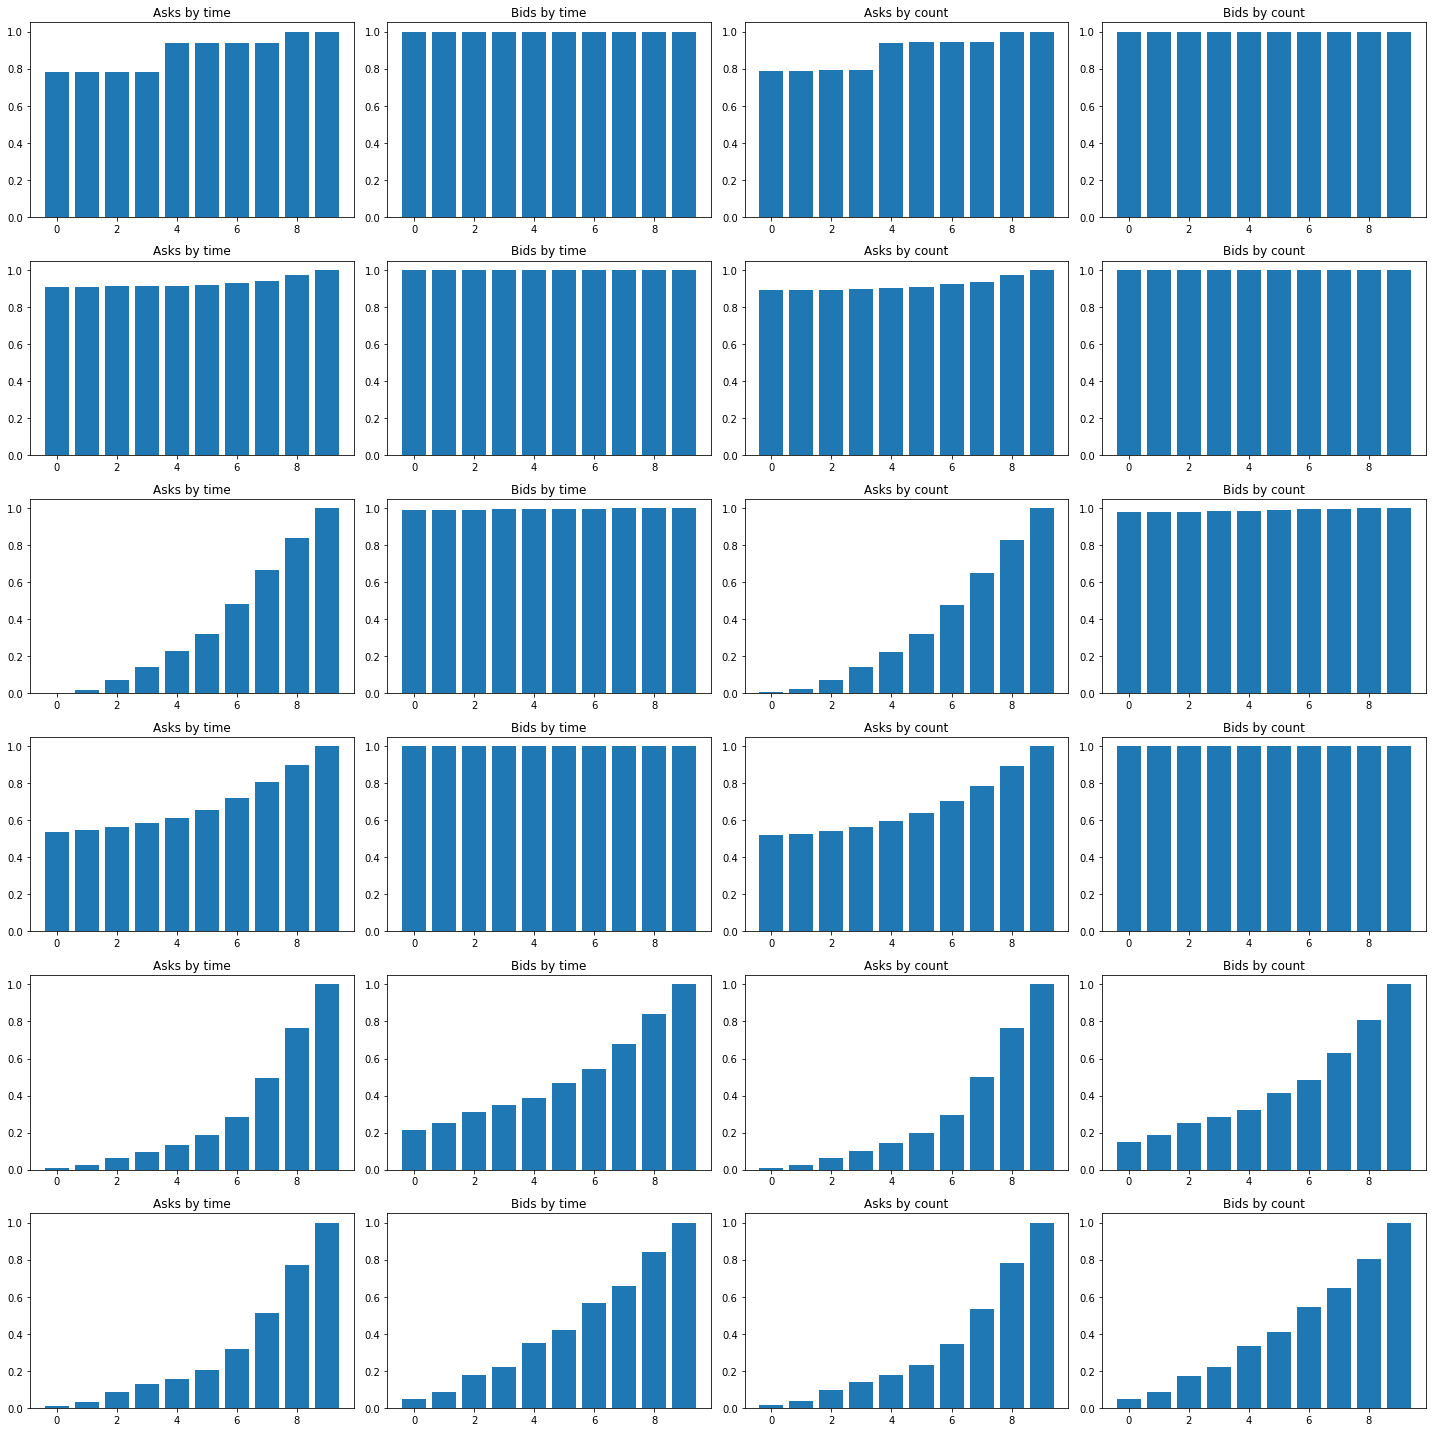

In [6]:
k = 1
plt.figure(figsize=(20,20))

for i in instruments:
    print('INSTRUMENT ' + i)
    filename = "spectrum/" + i + "_spectrum_day1.txt"
    avg_bids, avg_asks = norm_by_count(filename)
    weighted_avg_bids, weighted_avg_asks = weighted_norm(filename)

    kstest1 = kstest(avg_bids, avg_asks)
    kstest2 = kstest(weighted_avg_bids, weighted_avg_asks)
    kstest3 = kstest(avg_bids, weighted_avg_bids)
    kstest4 = kstest(avg_asks, weighted_avg_asks)

    if kstest1.pvalue < 0.025:
        print(f'For average by count bids and asks distributions are different, pval={kstest1.pvalue}')
    else:
        print(f'For average by count bids and asks distributions are the same, pval={kstest1.pvalue}')
        
    if kstest2.pvalue < 0.025:
        print(f'For average by time bids and asks distributions are different, pval={kstest2.pvalue}')
    else:
        print(f'For average by time bids and asks distributions are the same, pval={kstest2.pvalue}')
        
    if kstest3.pvalue < 0.025:
        print(f'For bids average by count and by time distributions are different, pval={kstest3.pvalue}')
    else:
        print(f'For bids average by count and by time distributions are the same, pval={kstest3.pvalue}')
        
    if kstest4.pvalue < 0.025:
        print(f'For asks average by count and by time distributions are different, pval={kstest4.pvalue}')
    else:
        print(f'For asks average by count and by time distributions are the same, pval={kstest4.pvalue}') 
        
    plt.subplot(6, 4, k)
    plt.bar(np.arange(10), weighted_avg_asks)
    plt.title('Asks by time')
    plt.subplot(6, 4, k+1)
    plt.bar(np.arange(10), weighted_avg_bids)
    plt.title('Bids by time')
    
    plt.subplot(6, 4, k+2)
    plt.bar(np.arange(10), avg_asks)
    plt.title('Asks by count')
    plt.subplot(6, 4, k+3)
    plt.bar(np.arange(10), avg_bids)
    plt.title('Bids by count')
    
    k += 4
    
        
    print('---------------------------------')
    
plt.tight_layout()

# KS-Test for all days

In [96]:
tom_instruments = ['EURUSD000TOM', 'EUR_RUB__TOM', 'USD000UTSTOM']

In [101]:
def another_norm_by_count(filename):
    sp = pd.read_csv(filename, header=None).to_numpy()
    max_time = np.max(sp[:, 0])
    
    if max_time > 150000000000:
        first = np.argwhere(sp[:, 0] > 150000000000)[0][0]
    else:
        results = np.array([np.mean(sp[:, 1:], axis=0), np.zeros(10), np.zeros(10)])
    if max_time > 190000000000:
        second = np.argwhere(sp[:, 0] > 190000000000)[0][0]
        results = np.array([np.mean(sp[:first, 1:], axis=0), np.mean(sp[first:second, 1:], axis=0), np.mean(sp[second:, 1:], axis=0)])
    else:
        results = np.array([np.mean(sp[:first, 1:], axis=0), np.mean(sp[first:, 1:], axis=0), np.zeros(10), np.zeros(10)])
        
    return np.cumsum(results[:, 0:10], axis=1), np.cumsum(results[:, 10:20], axis=1)
    
    
def another_weighted_norm(filename):
    start_time = np.array([100000000000])
    sp = pd.read_csv(filename, header=None)
    sp_np = sp.to_numpy()
    max_time = np.max(sp[0].to_numpy())
    total_time = sp[0].max() - 100000000000
    weights = np.diff(np.concatenate((start_time, sp[0].to_numpy())))
    results = np.array([np.zeros(20), np.zeros(20), np.zeros(20)])
    
    if max_time > 150000000000:
        first = np.argwhere(sp_np[:, 0] > 150000000000)[0][0]
    else:
        for index in range(1, 21):
            results[0, index - 1] = np.average(sp[index].to_numpy(), weights=weights)
    if max_time > 190000000000:
        second = np.argwhere(sp_np[:, 0] > 190000000000)[0][0]
        for index in range(1, 21):
            results[0, index - 1] = np.average(sp[index].to_numpy()[:first], weights=weights[:first])
            results[1, index - 1] = np.average(sp[index].to_numpy()[first:second], weights=weights[first:second])
            results[2, index - 1] = np.average(sp[index].to_numpy()[second:], weights=weights[second:])
    else:
        for index in range(1, 21):
            results[0, index - 1] = np.average(sp[index].to_numpy()[:first], weights=weights[:first])
            results[1, index - 1] = np.average(sp[index].to_numpy()[first:], weights=weights[first:])
    
    return np.cumsum(results[:, 0:10], axis=1), np.cumsum(results[:, 10:20], axis=1)

## Output 1: bids and asks for different times

In [108]:
pairs = [[0, 1], [1, 2], [0, 2]]
for i in tqdm(tom_instruments):
    f = open('task4_output1_' + i + '.txt', 'w+')
    f.write('10vs15; 15vs19; 10vs19\n')
    for j in tqdm(range(1, 65)):
        to_write = ''
        filename = "spectrum/" + i + "_spectrum_day" + str(j) + ".txt"
        avg_bids, avg_asks = another_norm_by_count(filename)
        for pair in pairs:
            kstest1 = kstest(avg_bids[pair[0]], avg_bids[pair[1]])
            kstest2 = kstest(avg_asks[pair[0]], avg_asks[pair[1]])
            if kstest1.pvalue < 0.025:
                to_write = to_write + 'false, '
            else:
                to_write = to_write + 'true, '
            if kstest2.pvalue < 0.025:
                to_write = to_write + 'false'
            else:
                to_write = to_write + 'true'
            to_write = to_write + '; '
        f.write(to_write[:-2] + '\n')

 95%|█████████████████████████████████████████████████████████████████████████████████▉    | 61/64 [03:30<00:08,  2.85s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [08:46<00:00, 175.35s/it]


## Output2: bids and asks for previous day

In [109]:
for i in tqdm(tom_instruments):
    f = open('task4_output2_' + i + '.txt', 'w+')
    f.write('10vs15; 15vs19; 10vs19\n')
    f.write('-; -; -\n')
    avg_bids_prev, avg_asks_prev = another_norm_by_count("spectrum/" + i + "_spectrum_day1.txt")
    for j in tqdm(range(2, 65)):
        to_write = ''
        filename = "spectrum/" + i + "_spectrum_day" + str(j) + ".txt"
        avg_bids, avg_asks = another_norm_by_count(filename)
        for k in range(3):
            kstest1 = kstest(avg_bids_prev[k], avg_bids[k])
            kstest2 = kstest(avg_asks_prev[k], avg_asks[k])
            if kstest1.pvalue < 0.025:
                to_write = to_write + 'false, '
            else:
                to_write = to_write + 'true, '
            if kstest2.pvalue < 0.025:
                to_write = to_write + 'false'
            else:
                to_write = to_write + 'true'
            to_write = to_write + '; '
        avg_bids_prev = avg_bids
        avg_asks_prev = avg_asks
        f.write(to_write[:-2] + '\n')

 98%|████████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [03:35<00:03,  3.10s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [08:39<00:00, 173.33s/it]


In [ ]:
def lab_12(midpoint_increments):
    for k in range(31):
        array1 = midpoint_increments[k:]
        array2 = midpoint_increments[:-k]
        cov = np.cov(a, b)
        return cov[0][1]/np.sqrt(cov[0][0]*cov[1][1])